## Objective
Run algorithm on spikeinterface recording

In [1]:
# region Set up notebook imports
%load_ext autoreload
%autoreload 2
# Reload a module after changes have been made
from importlib import reload
# endregion

import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster, linkage
from tqdm import tqdm

from src.prop_signal import v1_4 as ps_alg
from src import plot

from src.sorters.prop_signal import PropSignal, PropUnit
from src.sorters.kilosort import Kilosort
from src.comparison import Comparison
from src import utils

from src.recording import Recording

## Load spike times and recording

In [4]:
# Load spike times
recording_path = utils.PATH_REC_SI
CROSS_TIMES_PATH = "/data/MEAprojects/dandi/000034/sub-mouse412804/prop_signal/thresh_5_full/crossings.npy"
##
recording = Recording(recording_path, freq_max=3000)
CROSS_TIMES = np.load(CROSS_TIMES_PATH, allow_pickle=True)
CROSS_TIMES = PropSignal.format_thresh_crossings(CROSS_TIMES)

chans_rms = utils.chans_rms_si()

Recording does not have scaled traces. Setting gain to 0.195


In [5]:
np.argsort([-len(c) for c in CROSS_TIMES])

array([150,  12,  10,  26, 145, 148, 141, 152, 149, 143,  17,  13, 147,
        18, 156,  11, 209,  46, 208,   1,  20, 193,  14, 146,  97, 205,
        85, 153, 204,  30, 160, 139, 137,   8,  27, 213,  21,  23,  16,
        15,  42,  31, 140, 144, 207, 210,  49,  36, 206, 211,  25,  83,
        50, 158,  79, 155,  45,  29,  24,  33,  28, 136,  48,   9,  19,
        86,  78,  76,  47,  73,  74,  75, 124,  92, 135, 151,  98,  53,
        94, 142,  40,  77, 154,  43, 138, 227,  88, 215,  38, 157,  51,
        52, 133, 100, 202,  22,  55,  44,  82,  81, 221,  90,  96, 218,
       162,  54,  99,   7,  57, 164, 212, 230,  41, 203,  34,  89,  56,
        32, 134,  80,   5, 159, 214,  39, 125, 217, 225, 229, 223, 201,
        91,  72, 161,   6, 123, 165, 199,  84,  70,   2,   4, 226,  71,
       219, 102, 198, 232, 224,   0, 163, 237, 236,  93,  35, 238, 228,
       132, 195, 234, 233, 177, 101, 235, 231, 121, 242, 104, 222,  95,
       197, 131,  87, 166, 180,  59,  37, 240, 220, 194, 103, 19

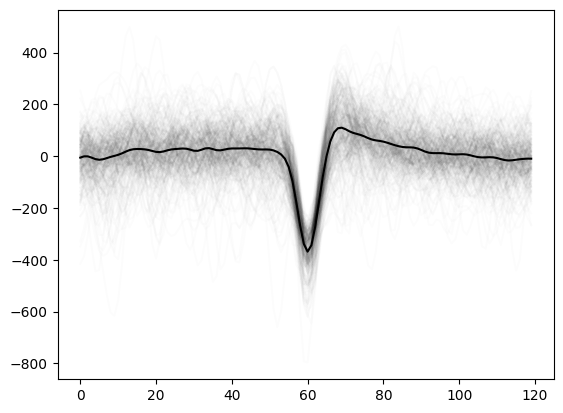

In [7]:
# Plot cross times on one channel
CHAN = 219
N = 300

N_BEFORE = 60
N_AFTER = 60

np.random.seed(231)
##
traces = [] 
for _ in range(N):
    time_ms = np.random.choice(CROSS_TIMES[CHAN])
    time = int(time_ms * recording.get_sampling_frequency())
    trace = recording.get_traces_filt(time-N_BEFORE, time+N_AFTER, CHAN).flatten()
    
    plt.plot(trace, color="black", alpha=0.01)
    
    traces.append(trace)
traces = np.stack(traces)
trace_mean = np.mean(traces, axis=0)
plt.plot(trace_mean, color="black")

plt.show()

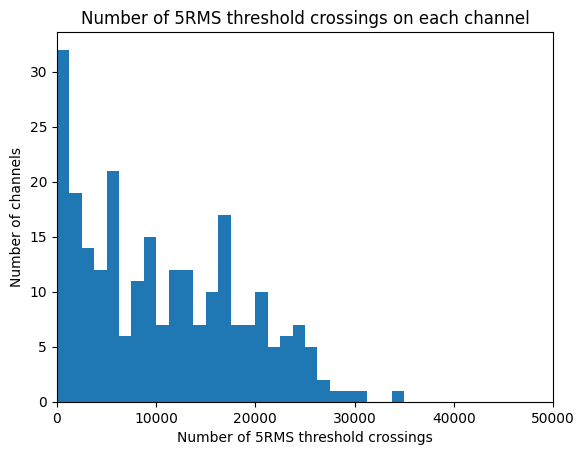

23/248 electrodes have fewer than 900 threshold crossings. 225 have greater.


In [6]:
# Plot distribution of crossings on each channel
num_crossings = np.array([len(c) for c in CROSS_TIMES])
plt.title("Number of 5RMS threshold crossings on each channel")
plt.hist(num_crossings, range=(0, 50000), bins=40)

plt.ylabel("Number of channels")
plt.xlabel("Number of 5RMS threshold crossings")
plt.xlim(0, 50000)

plt.show()

MIN_PROP_SPIKES = 1 * 15 * 60  # min_firing_rate * mins * 60_seconds_per_min
num_lower = np.sum(num_crossings < MIN_PROP_SPIKES)
print(f"{num_lower}/{len(num_crossings)} electrodes have fewer than {MIN_PROP_SPIKES} threshold crossings. {len(num_crossings) - num_lower} have greater.")

## Create candidate cohorts

In [7]:
candidate_cohorts = ps_alg.scan_reference_electrode(CROSS_TIMES, sampling_freq=30, min_prop_spikes=MIN_PROP_SPIKES, min_ccg_ratio=0.5,
                                                    ccg_before=1.5, ccg_after=1.5, ccg_small_window=0.5, ccg_big_window=2)

Scanning reference electrodes ...


  0%|          | 0/248 [00:00<?, ?it/s]

100%|██████████| 248/248 [02:30<00:00,  1.64it/s]


## Form propagations

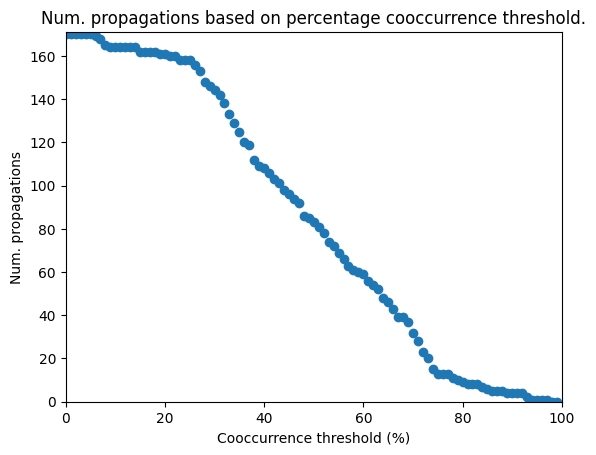

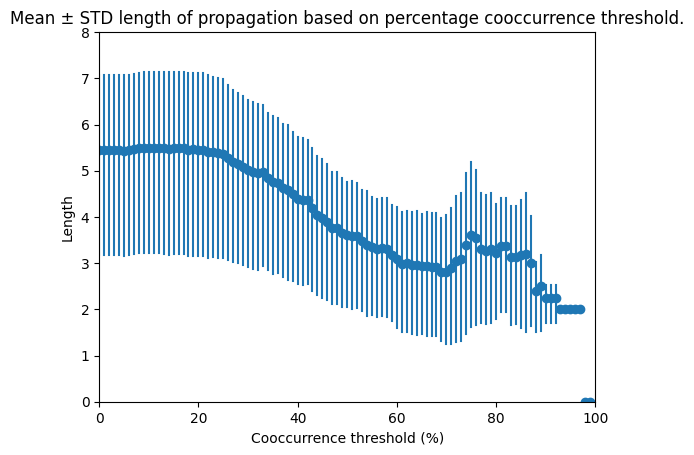

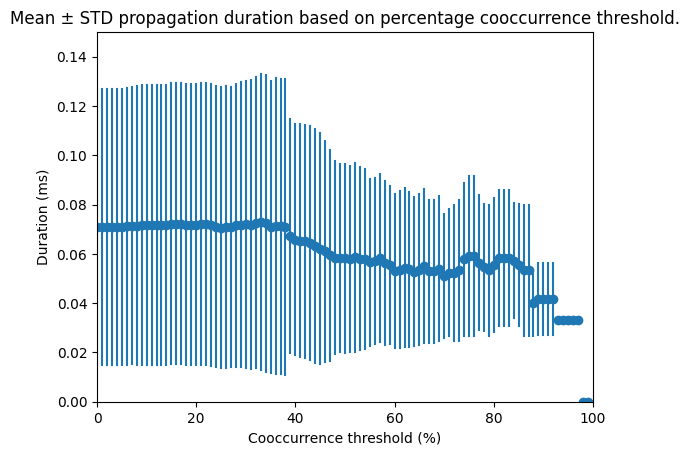

In [8]:
MIN_COCS_P_VALUES = range(0, 100)
##
nums_props = []

means_lens = []
stds_lens = []

means_durations = []
stds_durations = []
for min_cocs_p in MIN_COCS_P_VALUES:
    electrode_cohorts = ps_alg.rescan_candidate_cohorts(candidate_cohorts, max_latency=0.5,
                                                        min_cocs_n=0, min_cocs_p=min_cocs_p,
                                                        min_cocs_2_p=50)
    propagations = ps_alg.get_propagations(electrode_cohorts, min_duration=0.001)

    prop_lens = [len(p) for p in propagations]
    nums_props.append(len(prop_lens))

    if len(prop_lens) > 0:
        means_lens.append(np.mean(prop_lens))
        stds_lens.append(np.std(prop_lens))

        prop_durations = [PropSignal.get_sequence_duration(p) for p in propagations]
        means_durations.append(np.mean(prop_durations))
        stds_durations.append(np.std(prop_durations))
    else:
        means_lens.append(0)
        stds_lens.append(0)

        means_durations.append(0)
        stds_lens.append(0)

plt.title("Num. propagations based on percentage cooccurrence threshold.")
plt.xlabel("Cooccurrence threshold (%)")
plt.ylabel("Num. propagations")
plt.scatter(MIN_COCS_P_VALUES, nums_props)
plt.xlim(0, max(MIN_COCS_P_VALUES)+1)
plt.ylim(0, max(nums_props)+1)
plt.show()

plt.title("Mean ± STD length of propagation based on percentage cooccurrence threshold.")
plt.xlabel("Cooccurrence threshold (%)")
plt.ylabel("Length")
plt.scatter(MIN_COCS_P_VALUES, means_lens)
y_max = max(means_lens)+3
for thresh, mean, std in zip(MIN_COCS_P_VALUES, means_lens, stds_lens):
    plt.axvline(thresh, (mean-std)/y_max, (mean+std)/y_max)
plt.xlim(0, max(MIN_COCS_P_VALUES)+1)
plt.ylim(0, 8)
plt.show()

plt.title("Mean ± STD propagation duration based on percentage cooccurrence threshold.")
plt.xlabel("Cooccurrence threshold (%)")
plt.ylabel("Duration (ms)")
plt.scatter(MIN_COCS_P_VALUES, means_durations)
y_max = 0.15
for thresh, mean, std in zip(MIN_COCS_P_VALUES, means_durations, stds_durations):
    plt.axvline(thresh, (mean-std)/y_max, (mean+std)/y_max)
plt.xlim(0, max(MIN_COCS_P_VALUES)+1)
plt.ylim(0, y_max)
plt.show()

In [19]:
electrode_cohorts = ps_alg.rescan_candidate_cohorts(candidate_cohorts, max_latency=0.5,
                                                    min_cocs_n=0, min_cocs_p=30,
                                                    min_cocs_2_p=50)
propagations = ps_alg.get_propagations(electrode_cohorts, 0.001)
len(propagations)

144

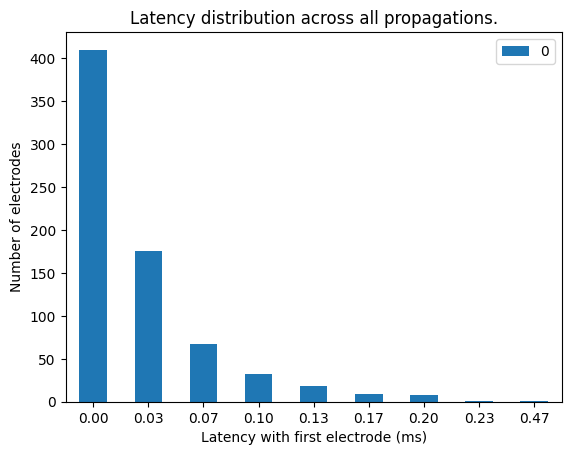

In [74]:
## Plot histogram of inter-electrode latencies
latencies = []
for prop in propagations:
    latencies.extend(prop.latency.values)
latencies, counts = np.unique(latencies, return_counts=True)
from pandas import DataFrame
df = DataFrame(counts, index=[f"{l:.2f}" for l in latencies])
df.plot.bar(rot=0)
plt.title("Latency distribution across all propagations.")
plt.xlabel("Latency with first electrode (ms)")
plt.ylabel("Number of electrodes")
plt.show()

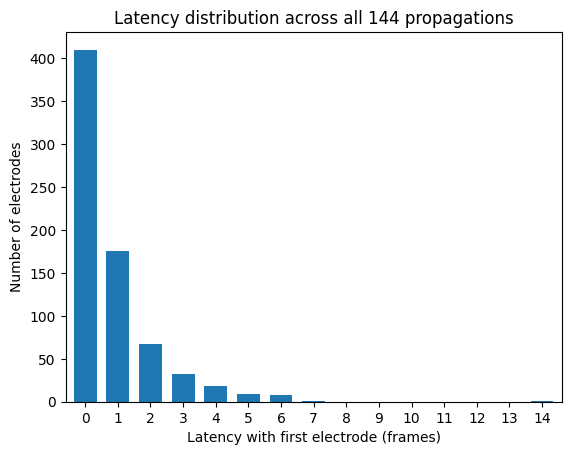

In [87]:
## Plot histogram of inter-electrode latencies
latencies = []
for prop in propagations:
    for l in prop.latency:
        latencies.append(round(l*30))

plot.bar(latencies)
plt.title(f"Latency distribution across all {len(propagations)} propagations")
plt.xlabel("Latency with first electrode (frames)")
plt.ylabel("Number of electrodes")
plt.show()

## Merge propagations

### Electrode overlap

In [9]:
def get_elec_overlap(prop_a, prop_b):
    elec_a = prop_a.ID.values
    elec_b = prop_b.ID.values
    _, overlap_a, overlap_b = np.intersect1d(elec_a, elec_b, return_indices=True, assume_unique=True)
    return overlap_a, overlap_b


def score_elec_overlap(prop_a, prop_b):
    elec_a = prop_a.ID.values
    elec_b = prop_b.ID.values

    overlap_a, overlap_b = get_elec_overlap(prop_a, prop_b)
    num_overlap = len(overlap_a)
    overlap_score = num_overlap / (len(elec_a) + len(elec_b) - num_overlap)
    return num_overlap, overlap_score * 100

### Sequence order overlap

In [125]:
def get_latency_pairs(latencies: np.ndarray):
    if latencies.size == 1:
        return latencies

    pairs = []
    for i in range(len(latencies)):
        for j in range(i+1, len(latencies)):
            diff  = latencies[i] - latencies[j]
            pairs.append(diff)
            
    return np.asarray(pairs)


def score_seq_order(prop_a, prop_b):
    overlap_a, overlap_b = get_elec_overlap(prop_a, prop_b)
    if overlap_a.size == 0:
        return np.nan

    latencies_a = prop_a.latency.values[overlap_a]
    latencies_b = prop_b.latency.values[overlap_b]
    # sums = np.sum(latencies_a) + np.sum(latencies_b)
    # if sums < 0.0001:
    #     return 0
    
    # Pairs
    # pairs_a = get_latency_pairs(latencies_a)
    # pairs_b = get_latency_pairs(latencies_b)
    # seq_score = np.sum(np.abs(pairs_a - pairs_b))
    # return seq_score / overlap_a.size

    # Deviation
    if overlap_a.size == 1:
        return 0    
    rel_latencies_a = latencies_a[1:] - latencies_a[0]
    rel_latencies_b = latencies_b[1:] - latencies_b[0]
    return np.mean(np.abs(rel_latencies_a - rel_latencies_b))
    

### Relative amplitude overlap

In [11]:
CROSS_AMPS = np.load("/data/MEAprojects/dandi/000034/sub-mouse412804/prop_signal/thresh_5_full/amplitudes.npy", allow_pickle=True)

#### Spike times and amplitudes for each propagation

In [20]:
PROP_AFTER = 0.5  # Coactivations must occur within PROP_AFTER ms
COACTIVATIONS_N_MIN = 2
COACTIVATIONS_P_MIN = 50
ISI_VIOL = 1.5


def get_prop_times_and_amps(prop):
    """_summary_
    For one propagations
    
    ref = crossing of first/anchor electrode in prop
    tar = crossing of another electrode in prop

    Args:
        prop (_type_): _description_

    Returns:
        _type_: _description_
    """

    coactivations_min = max(COACTIVATIONS_N_MIN, COACTIVATIONS_P_MIN/100 * len(prop))

    if len(prop) < coactivations_min:
        return np.array([]), np.array([np.nan for _ in range(len(prop))])
    
    ref_elec = prop.ID[0]
    ref_cross_times = CROSS_TIMES[ref_elec]
    ref_cross_amps = CROSS_AMPS[ref_elec]
    
    propagating_data = {}  # (ref_time, ref_amp) : [(tar1_elec, tar1_amp), (tar2_elec, tar2_amp), ...]
    for tar_elec in prop.ID[1:]:
        tar_cross_times = CROSS_TIMES[tar_elec]
        tar_cross_amps = CROSS_AMPS[tar_elec]
        
        for ref_time, ref_amp in zip(ref_cross_times, ref_cross_amps):
            # Find closest target cross
            i_tar = np.searchsorted(tar_cross_times, ref_time, side="left")
            
            # Count as coactivation if within PROP_AFTER
            if i_tar < len(tar_cross_times) and tar_cross_times[i_tar] <= ref_time + PROP_AFTER:
                ref = (ref_time, ref_amp)
                tar = (tar_elec, tar_cross_amps[i_tar])
                if ref not in propagating_data:
                    propagating_data[ref] = [tar]
                else:
                    propagating_data[ref].append(tar)
                    
    keys = list(propagating_data.keys())
    ref_times = [k[0] for k in keys]
    order = np.argsort(ref_times)
        
    propagating_times = []
    propagating_amps = {elec: [] for elec in prop.ID.values}  # elec : amps
    last_ref_time = -np.inf
    for idx in order:
        
        ref_time, ref_amp = keys[idx]
        tars = propagating_data[keys[idx]]
        if len(tars) + 1 < coactivations_min:  # +1 since being in list counts as 2 coactivations
            continue
        
        if ref_time <= last_ref_time + ISI_VIOL:  # ISI violation
            continue
        last_ref_time = ref_time
        
        propagating_times.append(ref_time)
        propagating_amps[ref_elec].append(ref_amp)
        for elec, amp in tars:
            propagating_amps[elec].append(amp)
        
    propagating_amps = np.array([np.mean(amps) for amps in propagating_amps.values()])
    
    return propagating_times, propagating_amps
        

def get_propagating_times_and_amps_all():
    # For all propagations
    propagating_times = []
    propagating_amps = []
    
    for prop in tqdm(propagations):
        prop_times, prop_amps = get_prop_times_and_amps(prop)
        propagating_times.append(prop_times)
        propagating_amps.append(prop_amps)
        
    return propagating_times, propagating_amps


# prop = propagations[0]
# print(prop)
# prop_times, prop_amps = get_prop_times_and_amps(prop)

propagating_times, propagating_amps = get_propagating_times_and_amps_all()

100%|██████████| 144/144 [00:21<00:00,  6.63it/s]


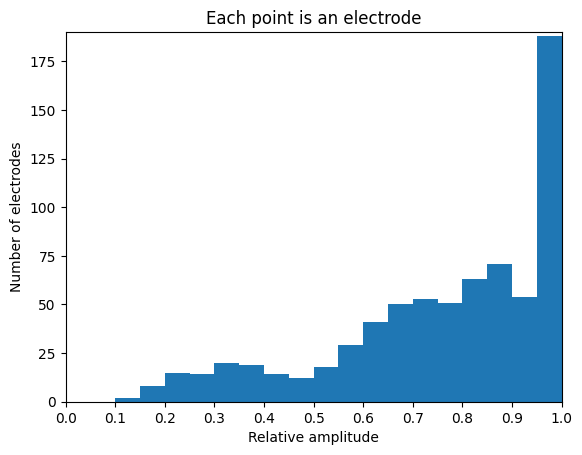

In [102]:
INCLUDE_MAX_ELEC = True  # Whether to include electrode with max amp (rel amp = 1) in histogram

hist_amps = []
for amps in propagating_amps:
    max_amp = np.max(amps)
    for amp in amps:
        if not INCLUDE_MAX_ELEC and amp == max_amp:
            continue
        hist_amps.append(amp / np.max(amps))
        
plot.hist(hist_amps, xlim=(0, 1), bins=np.arange(0, 1.01, 0.05))

title = "Each point is an electrode"
if not INCLUDE_MAX_ELEC:
    title += ", not including max elec"
plt.title(title)

plt.xlabel("Relative amplitude")
plt.xticks(np.arange(0, 1.001, 0.1))

plt.ylabel("Number of electrodes")
plt.ylim(0, 190)

plt.show()

#### Relative amplitude overlap score

In [13]:
def score_rel_amp(idx_a, idx_b):
    """_summary_

    Args:
        idx_a (_type_): _description_
        idx_b (_type_): _description_
    """
    prop_a = propagations[idx_a]
    prop_b = propagations[idx_b]
    overlap_a, overlap_b = get_elec_overlap(prop_a, prop_b)
    
    if overlap_a.size == 0:
        return np.nan
    
    amps_a = propagating_amps[idx_a][overlap_a]
    amps_b = propagating_amps[idx_b][overlap_b]
    
    rel_elec = np.argmax(amps_a)  # Which electrode to have amps relative to
    rel_amps_a = amps_a / amps_a[rel_elec]
    rel_amps_b = amps_b / amps_b[rel_elec]
        
    # print(prop_a.ID.values[overlap_a])
    # print(prop_b.ID.values[overlap_b])
        
    # print(amps_a)
    # print(amps_b)
        
    # print(overlap_a[rel_elec])
    # print(rel_amps_a)
    # print(rel_amps_b)
        
    diff = np.abs(rel_amps_a - rel_amps_b)
    return np.sum(diff) / diff.size

### Merge

In [14]:
MERGE_METHOD = "average"

# Probably don't change this unless revamping merging process
MERGE_CRITERION = "distance"

In [127]:
def get_pair_merge_scores(i_a, i_b):
    prop_a = propagations[i_a]
    prop_b = propagations[i_b]

    elec_score_n, elec_score_p = score_elec_overlap(prop_a, prop_b)
    seq_score = score_seq_order(prop_a, prop_b)
    rel_amp_score = score_rel_amp(i_a, i_b)
    
    return elec_score_n, elec_score_p, seq_score, rel_amp_score

def get_merge_scores():
    merge_scores = []
    ind_a, ind_b = np.triu_indices(len(propagations), k=1)
    for i_a, i_b in zip(ind_a, ind_b):
        merge_scores.append(get_pair_merge_scores(i_a, i_b))
    return np.asarray(merge_scores)


def merge(dist_max, return_times=False, isi_viol=1.5):
    linkage_m = linkage(pdist, method=MERGE_METHOD)
    clusters = fcluster(linkage_m, dist_max, criterion=MERGE_CRITERION)
    
    propagations_merged = {}
    for i, c in enumerate(clusters):
        if c not in propagations_merged:
            propagations_merged[c] = [propagations[i]]
        else:
            propagations_merged[c].append(propagations[i])
          
    # IDK why pms are sorted by cluster ID
    # pm_order = sorted(c for c in propagations_merged.keys())
    # propagations_merged = [propagations_merged[c] for c in pm_order]
    
    # Sort pms by first electrode ID
    pm_ids = []
    elec_ids = []
    for p in propagations_merged.keys():
        pm_ids.append(p)
        elec_ids.append(min(prop.ID[0] for prop in propagations_merged[p]))
    pm_order = [pm_ids[e] for e in np.argsort(elec_ids)]
    propagations_merged = [propagations_merged[o] for o in pm_order]
        
    # Get spike times
    if not return_times:
        return propagations_merged
    else:
         # Get which propagation belongs to which merge 
        propagating_times_merged = {}
        for i, c in enumerate(clusters): 
            if c not in propagating_times_merged:
                propagating_times_merged[c] = propagating_times[i][:]
            else:
                propagating_times_merged[c].extend(propagating_times[i])
                
        # Sort propagation times and prevent ISI violations
        propagating_times_merged_sorted = []
        for c in pm_order:
            pu_times = propagating_times_merged[c]  # pu = propagations un-properly formatted 
            pu_times = np.sort(pu_times)
            
            last_time = pu_times[0]
            pm_times = [last_time]
            
            for t in range(1, pu_times.size):
                time = pu_times[t]
                if time - last_time > isi_viol:
                    pm_times.append(time)
                    last_time = time
            propagating_times_merged_sorted.append(np.array(pm_times))
    
        return propagations_merged, propagating_times_merged_sorted

merge_scores = get_merge_scores()

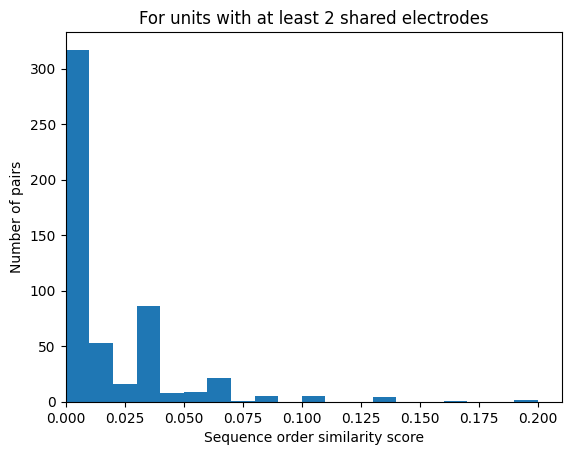

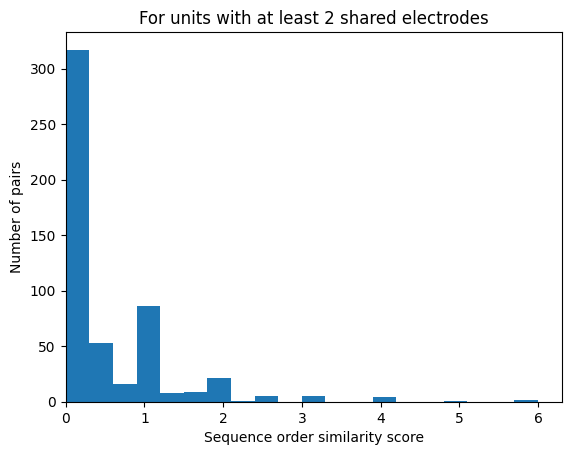

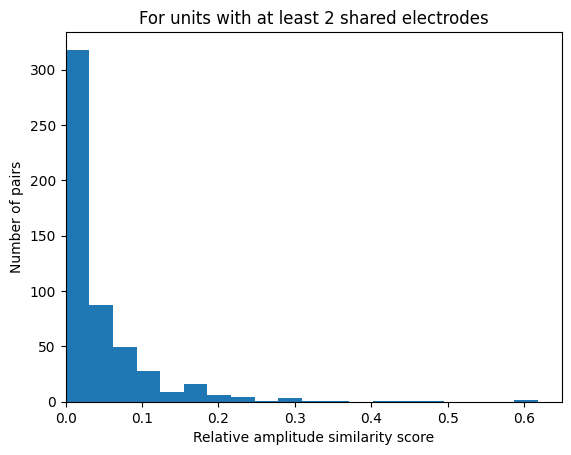

In [152]:
# Distribution of scores of pairs that have at least 2 shared electrodes
seq_order_scores = []
rel_amp_scores = []
for i in range(len(propagations)):
    for j in range(i+1, len(propagations)):
        elec_n, elec_p, seq, rel = get_pair_merge_scores(i, j)
        seq_order_scores.append(seq)
        rel_amp_scores.append(rel)

# Sequence order
plot.hist(seq_order_scores, bins=20)

plt.title("For units with at least 2 shared electrodes")
plt.xlabel("Sequence order similarity score")
plt.xlim(0)
plt.ylabel("Number of pairs")
plt.show()

plot.hist(np.array(seq_order_scores)*recording.get_sampling_frequency(), bins=20)

plt.title("For units with at least 2 shared electrodes")
plt.xlabel("Sequence order similarity score")
plt.xlim(0)
plt.ylabel("Number of pairs")
plt.show()

# Relative amplitude

plot.hist(rel_amp_scores, bins=20)

plt.title("For units with at least 2 shared electrodes")
plt.xlabel("Relative amplitude similarity score")
plt.xlim(0)
plt.ylabel("Number of pairs")
plt.show()

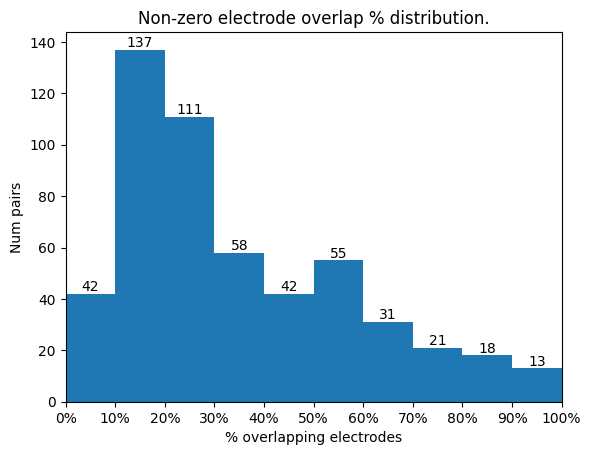

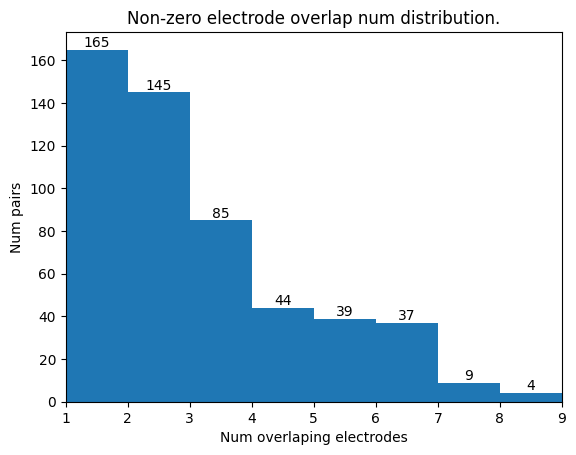

In [22]:
#### ELECTRODE OVERLAP ####

# Graph distribution of electrode overlap scores
nums = []
scores = []
ind_a, ind_b = np.triu_indices(len(propagations), k=1)
for i_a, i_b in zip(ind_a, ind_b):
    prop_a = propagations[i_a]
    prop_b = propagations[i_b]
    num, score = score_elec_overlap(prop_a, prop_b)
    
    if score > 0:
        scores.append(score)
        nums.append(num)
# Create plot
plt.title("Non-zero electrode overlap % distribution.")
plt.xlabel("% overlapping electrodes")
plot.hist(scores, bins=np.arange(0, 101, 10), labels=True)
plt.ylabel("Num pairs")
plt.xlim(0, 100)
plt.xticks(np.arange(0, 101, 10), [f"{r}%" for r in np.arange(0, 101, 10)])
plt.show()

plt.title("Non-zero electrode overlap num distribution.")
plt.xlabel("Num overlaping electrodes")
plot.hist(nums, bins=max(nums)-1, labels=True)
plt.ylabel("Num pairs")
plt.xlim(1, max(nums))
plt.show()

In [120]:
ELEC_OVERLAP_N_MIN = 2 # 2
ELEC_OVERLAP_P_MIN = 50
no_merge_ind_elec = (merge_scores[:, 0] < ELEC_OVERLAP_N_MIN) | (merge_scores[:, 1] < ELEC_OVERLAP_P_MIN)


Num. propagations: 144


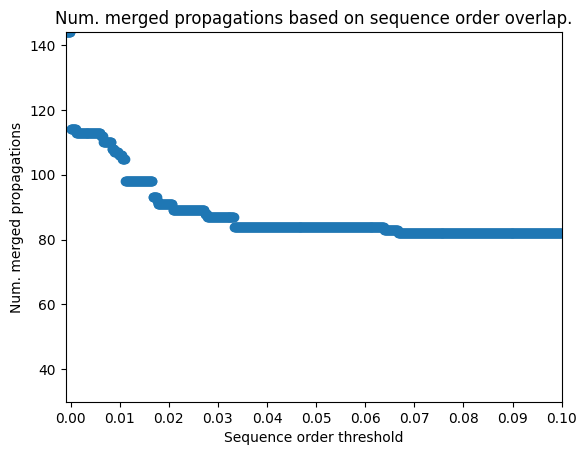

In [137]:

#### SEQUENCE ORDER ####
SEQ_ORDER_EXTREMUM = 100000  # Value to assign prop pairs that should not be merged
SEQ_ORDER_MAX_VALUES = np.linspace(-0.001, 0.1, num=1000)  # Values to test in plot
##

pdist = merge_scores[:, 2].copy()
pdist[no_merge_ind_elec] = SEQ_ORDER_EXTREMUM

nums_merges = []
means_lens = []
stds_lens = []
for seq_order_max in SEQ_ORDER_MAX_VALUES:
    prop_lens = [len(p) for p in merge(seq_order_max)]
    
    nums_merges.append(len(prop_lens))
    if len(prop_lens) > 0:
        means_lens.append(np.mean(prop_lens))
        stds_lens.append(np.std(prop_lens))
    else:
        means_lens.append(0)
        stds_lens.append(0)

print(f"Num. propagations: {len(propagations)}")

# Create plot
plt.title("Num. merged propagations based on sequence order overlap.")
plt.xlabel("Sequence order threshold")
plt.ylabel("Num. merged propagations")
plt.scatter(SEQ_ORDER_MAX_VALUES, nums_merges)
plt.xlim(min(SEQ_ORDER_MAX_VALUES), max(SEQ_ORDER_MAX_VALUES))
plt.xticks(np.arange(11)/100)
plt.ylim(30, len(propagations))
plt.show()

# plt.title("Mean ± STD num. propagations in a merge")
# plt.xlabel("Sequence order threshold")
# plt.ylabel("Num. propagations in merge")
# plt.scatter(SEQ_ORDER_VALUES, means_lens)
# y_max = 2.5  # means_lens[1] + 1
# for thresh, mean, std in zip(SEQ_ORDER_VALUES, means_lens, stds_lens):
#     plt.axvline(thresh, (mean-std)/y_max, (mean+std)/y_max, alpha=0.1)
# plt.xlim(min(SEQ_ORDER_VALUES), max(SEQ_ORDER_VALUES))
# plt.ylim(0, y_max)
# plt.show()

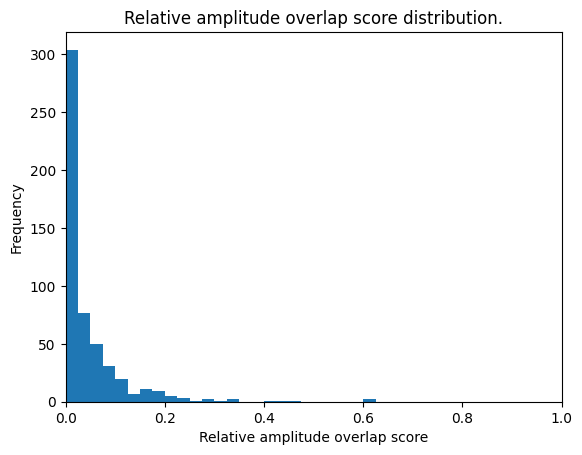

In [32]:
plt.hist(merge_scores[:, 3], range=(0, 1), bins=40)
plt.title("Relative amplitude overlap score distribution.")
plt.xlabel("Relative amplitude overlap score")
plt.ylabel("Frequency")
plt.xlim(0, 1)
plt.show()

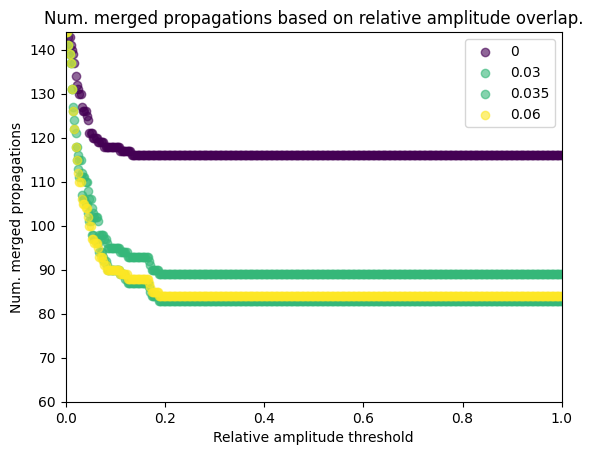

In [129]:
#### RELATIVE AMPLITUDE ####
REL_AMP_EXTREMUM = 100000  # Value to assign prop pairs that should not be merged

REL_AMP_MAX_VALUES = np.linspace(0, 1, num=400)  # Values to test in plot

SEQ_ORDER_MAX_VALUES = [0, 0.03, 0.035, 0.06]
CMAP = plt.cm.get_cmap("viridis", len(SEQ_ORDER_MAX_VALUES))
##
norm = plt.Normalize(SEQ_ORDER_MAX_VALUES[0], SEQ_ORDER_MAX_VALUES[-1])
for seq_order_max in SEQ_ORDER_MAX_VALUES:    
    no_merge_ind_seq = no_merge_ind_elec | (merge_scores[:, 2] > seq_order_max)

    pdist = merge_scores[:, 3].copy()
    pdist[no_merge_ind_seq] = REL_AMP_EXTREMUM

    nums_merges = []
    means_lens = []
    stds_lens = []
    for rel_amp_max in REL_AMP_MAX_VALUES:
        prop_lens = [len(p) for p in merge(rel_amp_max)]
        
        nums_merges.append(len(prop_lens))
        if len(prop_lens) > 0:
            means_lens.append(np.mean(prop_lens))
            stds_lens.append(np.std(prop_lens))
        else:
            means_lens.append(0)
            stds_lens.append(0)
            
    color = CMAP(norm(seq_order_max))
    plt.scatter(REL_AMP_MAX_VALUES, nums_merges, color=color, label=seq_order_max, alpha=0.6)
# print(f"Num. propagations: {len(propagations)}")

# Create plot
plt.title("Num. merged propagations based on relative amplitude overlap.")
plt.xlabel("Relative amplitude threshold")
plt.ylabel("Num. merged propagations")
# plt.scatter(REL_AMP_MAX_VALUES, nums_merges)
plt.xlim(min(REL_AMP_MAX_VALUES), max(REL_AMP_MAX_VALUES))
plt.ylim(60, len(propagations))
plt.legend()
plt.show()

# plt.title("Mean ± STD num. propagations in a merge")
# plt.xlabel("Sequence order threshold")
# plt.ylabel("Num. propagations in merge")
# plt.scatter(SEQ_ORDER_VALUES, means_lens)
# y_max = 2.5  # means_lens[1] + 1
# for thresh, mean, std in zip(SEQ_ORDER_VALUES, means_lens, stds_lens):
#     plt.axvline(thresh, (mean-std)/y_max, (mean+std)/y_max, alpha=0.1)
# plt.xlim(min(SEQ_ORDER_VALUES), max(SEQ_ORDER_VALUES))
# plt.ylim(0, y_max)
# plt.show()

#### Final merge

In [141]:
SEQ_ORDER_MAX = 0.03
REL_AMP_MAX = 0.2
MERGE_METHOD = "average"

Num propagations: 144
Num merged propagations: 89
Mean: 8438.06
STD: 5892.64


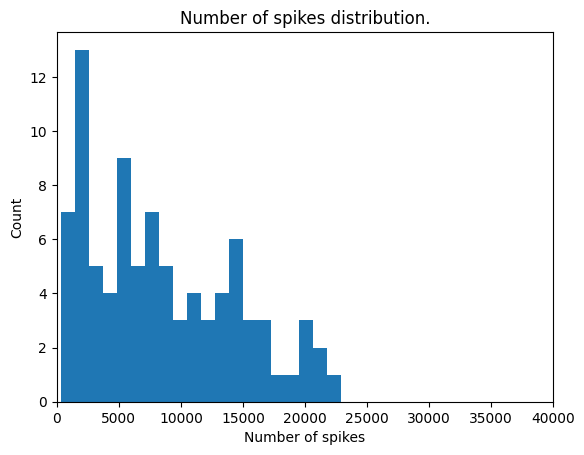

In [144]:
ELEC_OVERLAP_N_MIN = 2
ELEC_OVERLAP_P_MIN = 50
no_merge_ind_elec = (merge_scores[:, 0] < ELEC_OVERLAP_N_MIN) | (merge_scores[:, 1] < ELEC_OVERLAP_P_MIN)

no_merge_ind_seq = no_merge_ind_elec | (merge_scores[:, 2] > SEQ_ORDER_MAX)

pdist = merge_scores[:, 3].copy()
pdist[no_merge_ind_seq] = REL_AMP_EXTREMUM

propagations_merged, propagating_times_merged = merge(REL_AMP_MAX, return_times=True)
print(f"Num propagations: {len(propagations)}")
print(f"Num merged propagations: {len(propagations_merged)}")

prop_signal = PropSignal((propagations_merged, propagating_times_merged), recording)
prop_signal.plot_nums_spikes(show=False, bins=20)
plt.xlim(0, 40000)
plt.show()

In [18]:
# prop_signal = PropSignal("/data/MEAprojects/dandi/000034/sub-mouse412804/prop_signal/230718", recording)

## Manually merge

In [ ]:
prop_signal = PropSignal((propagations, propagating_times), recording)
for prop in prop_signal:
    print(prop.idx)
    prop.plot(chans_rms=chans_rms)

## Save prop signal

In [248]:
# prop_signal.save("/data/MEAprojects/dandi/000034/sub-mouse412804/prop_signal/230718")

/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


## Plot propagations

In [ ]:
for idx in range(0, len(prop_signal), 1):
    prop_signal[idx].plot()

## Examine spike splittng problem

In [65]:
def df_to_prop_idx(df):
    # pandas dataframe to idx in variable "propagations"
    for idx in range(len(propagations)):
        prop = propagations[idx]
        if len(df.ID) == len(prop.ID) and np.all(df.ID == prop.ID):
            return idx
    return None

100%|██████████| 89/89 [00:03<00:00, 24.03it/s]


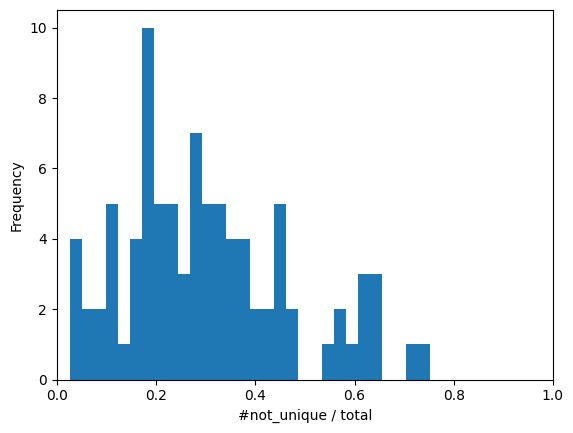

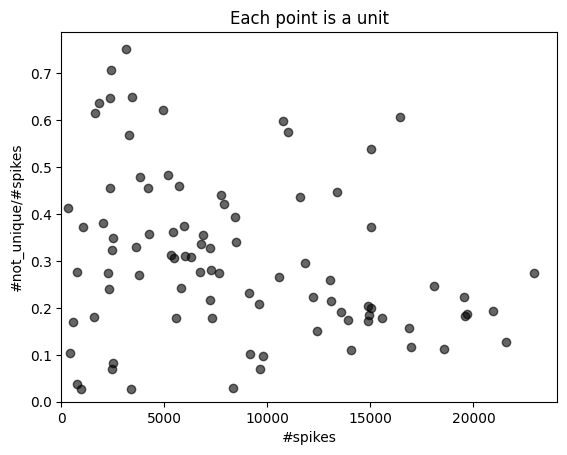

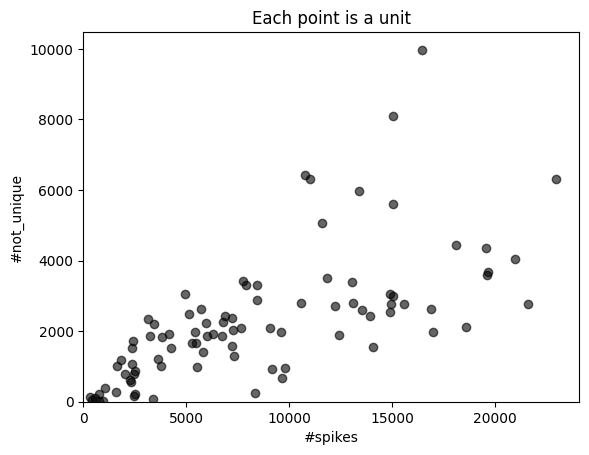

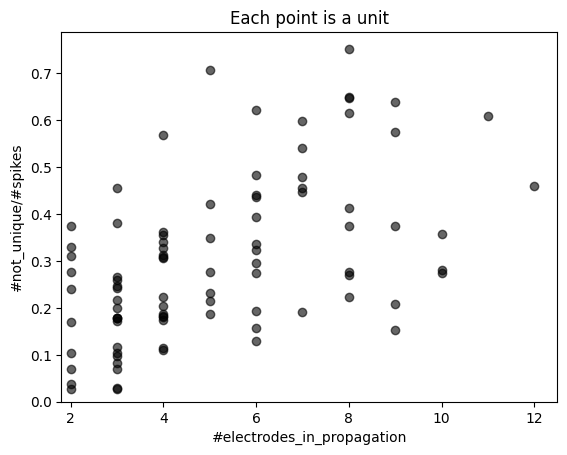

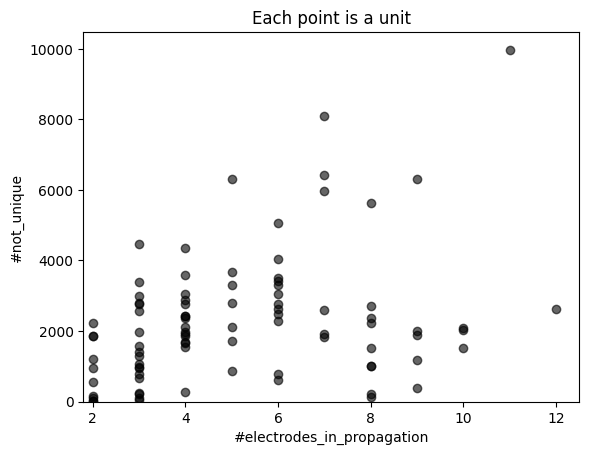

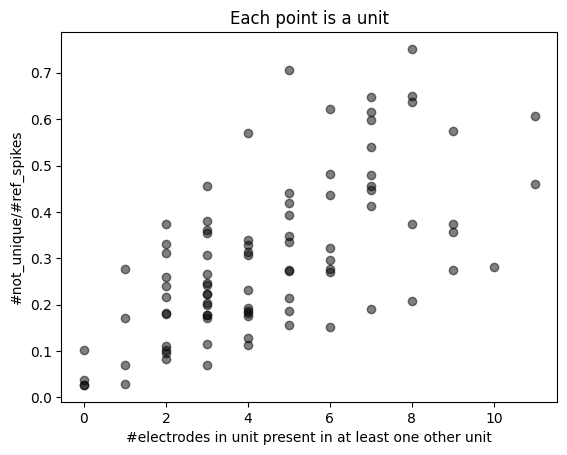

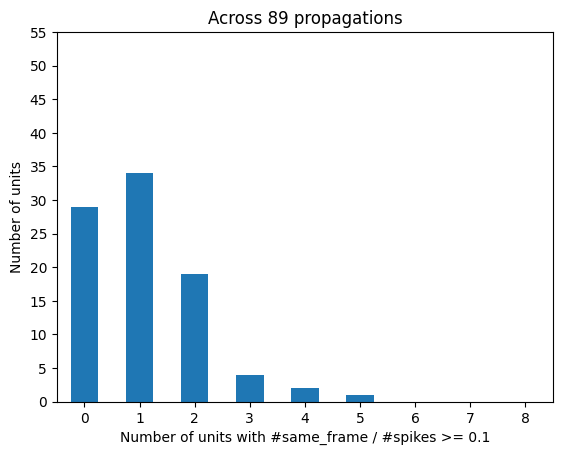

In [145]:
spike_train_sets = []
spike_trains = prop_signal.get_spike_times()
for train in spike_trains:
    spike_train_sets.append(set(train))

overlap_ratios = []  # ith value = #not_unique/#total for spikes of ith propagation
overlap_matrix = np.zeros((len(prop_signal), len(prop_signal)), dtype=float)  # [i, j] = num overlaps between units i and j / num spikes i
for i in tqdm(range(len(prop_signal))):
    unique = spike_train_sets[i]
    for j in range(len(prop_signal)):
        if i == j:
            continue
        overlap_matrix[i, j] = len(spike_train_sets[i].intersection(spike_train_sets[j])) / len(spike_train_sets[i])
        unique = unique.difference(spike_train_sets[j])
    overlap_ratios.append(
        (len(spike_train_sets[i]) - len(unique)) / (len(spike_train_sets[i]))
    )
    
plt.hist(overlap_ratios, bins=30)
plt.yticks(range(0, 12, 2))

plt.ylabel("Frequency")
plt.xlabel("#not_unique / total")
plt.xlim(0, 1)
plt.show()

for i in range(len(prop_signal)):
    plt.scatter(len(prop_signal[i]), overlap_ratios[i], color="black", alpha=0.6)
plt.xlim(0)
plt.ylim(0)
plt.title("Each point is a unit")
plt.ylabel("#not_unique/#spikes")
plt.xlabel("#spikes")
plt.show()

for i in range(len(prop_signal)):
    plt.scatter(len(prop_signal[i]), overlap_ratios[i]*len(prop_signal[i]), color="black", alpha=0.6)
plt.xlim(0)
plt.ylim(0)
plt.title("Each point is a unit")
plt.ylabel("#not_unique")
plt.xlabel("#spikes")
plt.show()
for i in range(len(prop_signal)):
    plt.scatter(len(prop_signal[i].chans), overlap_ratios[i], color="black", alpha=0.6)
plt.xlim(1.8)
plt.ylim(0)
plt.title("Each point is a unit")
plt.ylabel("#not_unique/#spikes")
plt.xlabel("#electrodes_in_propagation")
plt.show()
for i in range(len(prop_signal)):
    plt.scatter(len(prop_signal[i].chans), overlap_ratios[i]*len(prop_signal[i]), color="black", alpha=0.6)
plt.xlim(1.8)
plt.ylim(0)
plt.title("Each point is a unit")
plt.ylabel("#not_unique")
plt.xlabel("#electrodes_in_propagation")
plt.show()
prop_elecs = []

for i in range(len(prop_signal)):
    elecs = set()
    for df in prop_signal[i].df:
        elecs.update(df.ID)
    prop_elecs.append(elecs)

for i in range(len(prop_signal)):
    elecs = prop_elecs[i]
    num_elecs = len(elecs)
    for j in range(len(prop_signal)):
        if i == j:
            continue
        elecs = elecs.difference(prop_elecs[j])
    
    plt.scatter(num_elecs - len(elecs), overlap_ratios[i], color="black", alpha=0.5)

plt.title("Each point is a unit")
plt.xlabel("#electrodes in unit present in at least one other unit")
plt.ylabel("#not_unique/#ref_spikes")
plt.show()
from pandas import DataFrame

OVERLAP_MIN = 0.1  # If two units have #not_unique/#spikes >= OVERLAP_MIN, then they overlap
MAX_BAR = 8  # Bar plot will go up to this 

##
counts = []
for i in range(len(prop_signal)):
    counts.append(np.sum(overlap_matrix[i, :] >= OVERLAP_MIN))
bars, bar_counts = np.unique(counts, return_counts=True)

bar_counts = bar_counts.tolist() + [0] * (MAX_BAR - bars[-1])
bars = bars.tolist() + list(range(bars[-1]+1, MAX_BAR+1))

df = DataFrame(data=bar_counts, index=bars)
df.plot.bar(rot=0, legend=False)

plt.title(f"Across {len(prop_signal)} propagations")
plt.xlabel(f"Number of units with #same_frame / #spikes >= {OVERLAP_MIN}")
plt.ylabel("Number of units")
# plt.yticks(range(0, 33, 4))
plt.yticks(range(0, 60, 5))

plt.show()


In [146]:
def plot_sharing_props(ref_idx, vmax=None, ylim=None, chans_rms=None):
    # Two props are sharing if #spikes_same_frame/#ref_spikes >= OVERLAP_MIN
    ref_unit = prop_signal[ref_idx]
    kwargs = ref_unit.plot(vmax=vmax, ylim=ylim, chans_rms=chans_rms, return_kwargs=True)
    print(f"#spikes: {len(ref_unit)}")
    print(f"#not_unique/#ref_spikes: {overlap_ratios[ref_idx]:.3f}")
    print(f"#sharing units: {counts[ref_idx]}")
    ref_prop_ind = [df_to_prop_idx(df) for df in ref_unit.df]
        
    for comp_idx in range(len(prop_signal)):
        share_score = overlap_matrix[ref_idx, comp_idx]
        if share_score >= OVERLAP_MIN:
            comp_unit = prop_signal[comp_idx]
            comp_unit.plot(**kwargs)
            print(f"#spikes: {len(comp_unit)}\n#not_unique/#ref_spikes {share_score:.3f}")
            
            merge_elec_n = np.zeros((len(ref_prop_ind), len(comp_unit.df)), dtype=int)
            merge_elec_p = np.zeros_like(merge_elec_n, dtype=float)
            merge_seq = np.zeros_like(merge_elec_n, dtype=float)
            merge_rel = np.zeros_like(merge_elec_n, dtype=float)
            
            for r, ref_prop_idx in enumerate(ref_prop_ind):
                print(ref_unit.df[r].ID[0])
                for c, df in enumerate(comp_unit.df):
                    # elec_n, elec_p, seq, rel = get_pair_merge_scores(ref_prop_idx, df_to_prop_idx(df))
                    # merge_elec_n[r, c] = elec_n
                    # merge_elec_p[r, c] = elec_p
                    # merge_seq[r, c] = seq
                    # merge_rel[r, c] = rel
                    print_merge_scores(get_pair_merge_scores(ref_prop_idx, df_to_prop_idx(df)))
                    
            # merge_scores = np.array(merge_scores)
            # merge_means = np.mean(merge_scores, axis=0)
            # merge_stds = np.std(merge_scores, axis=0)
            # print_merge_scores(merge_means)
        
        
def print_merge_scores(merge_scores):
    print(f"Elec overlap: {merge_scores[0]} elecs = {merge_scores[1]:.1f}%")
    print(f"Sequence order score: {merge_scores[2]:.3f}")
    print(f"Rel amplitude score: {merge_scores[3]:.3f}")
    print()

counts_argsort = np.argsort(counts)
print(counts_argsort)

[44 29 31 32 38 39 41 42 87 45 48 56 58 62 63 64 68 77 28 20 88 10 19 12
  7 13  6  5  4 21 51 52 55 59  3  2 72 73 75 76 78 81 82 83 84 85 86 50
 49 54  0 33 35 36 16 26 15 11 43 23 22 46 40 24 25 79 18  1 17 74 27 47
  8  9 66 34 61 71 60 37 14 57 80 30 65 53 69 67 70]


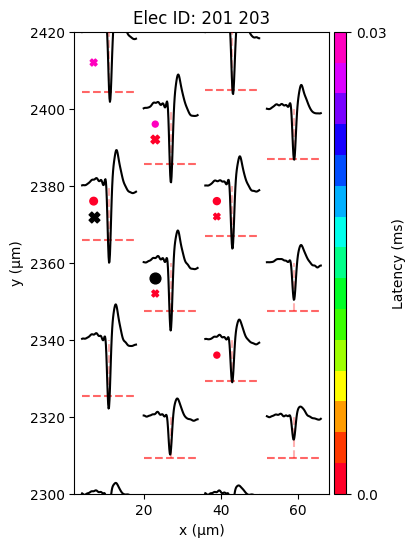

#spikes: 4915
#not_unique/#ref_spikes: 0.622
#sharing units: 5


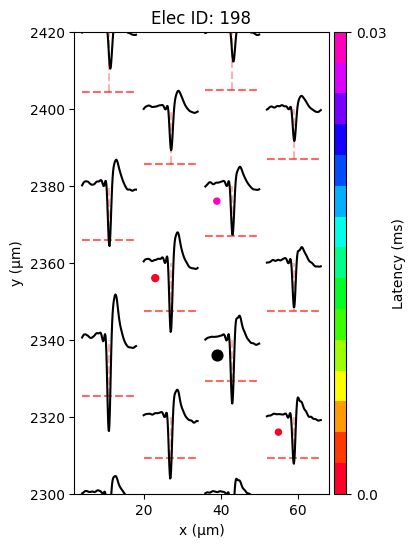

#spikes: 3261
#not_unique/#ref_spikes 0.205
201
Elec overlap: 3 elecs = 50.0%
Sequence order score: 0.017
Rel amplitude score: 0.109

203
Elec overlap: 2 elecs = 28.6%
Sequence order score: 0.033
Rel amplitude score: 0.086



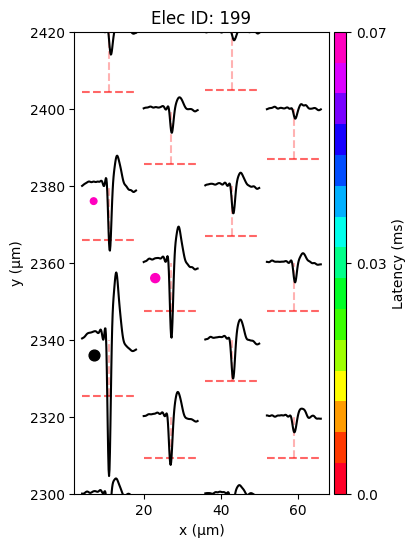

#spikes: 5795
#not_unique/#ref_spikes 0.118
201
Elec overlap: 2 elecs = 33.3%
Sequence order score: 0.000
Rel amplitude score: 0.013

203
Elec overlap: 2 elecs = 33.3%
Sequence order score: 0.000
Rel amplitude score: 0.043



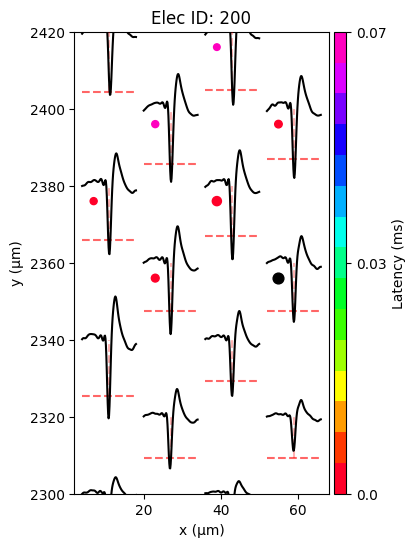

#spikes: 1647
#not_unique/#ref_spikes 0.106
201
Elec overlap: 4 elecs = 44.4%
Sequence order score: 0.000
Rel amplitude score: 0.048

203
Elec overlap: 4 elecs = 44.4%
Sequence order score: 0.011
Rel amplitude score: 0.059



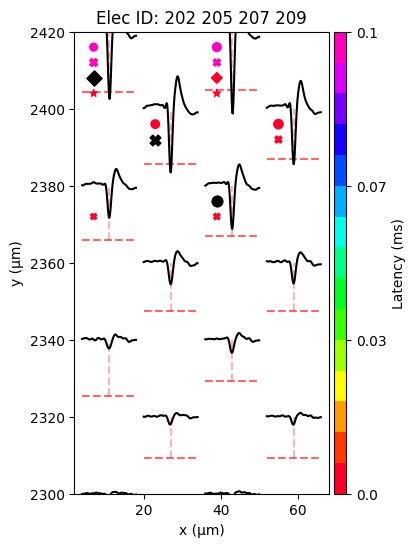

#spikes: 16416
#not_unique/#ref_spikes 0.235
201
Elec overlap: 2 elecs = 16.7%
Sequence order score: 0.033
Rel amplitude score: 0.076

Elec overlap: 3 elecs = 25.0%
Sequence order score: 0.017
Rel amplitude score: 0.202

Elec overlap: 0 elecs = 0.0%
Sequence order score: nan
Rel amplitude score: nan

Elec overlap: 0 elecs = 0.0%
Sequence order score: nan
Rel amplitude score: nan

203
Elec overlap: 3 elecs = 27.3%
Sequence order score: 0.000
Rel amplitude score: 0.041

Elec overlap: 4 elecs = 36.4%
Sequence order score: 0.000
Rel amplitude score: 0.045

Elec overlap: 1 elecs = 9.1%
Sequence order score: 0.000
Rel amplitude score: 0.000

Elec overlap: 1 elecs = 9.1%
Sequence order score: 0.000
Rel amplitude score: 0.000



KeyboardInterrupt: 

In [163]:
plot_sharing_props(70, chans_rms=chans_rms)

In [57]:
# Select specific units to examine
UNIT_IND = np.argsort(overlap_ratios)[:10]
print(UNIT_IND)
print(np.array(overlap_ratios)[UNIT_IND])

[69 46 45 70  7 95 48 23 64 71]
[0.02703506 0.02923556 0.02991453 0.04145078 0.07161418 0.07198048
 0.08449028 0.0968434  0.1016034  0.10311751]


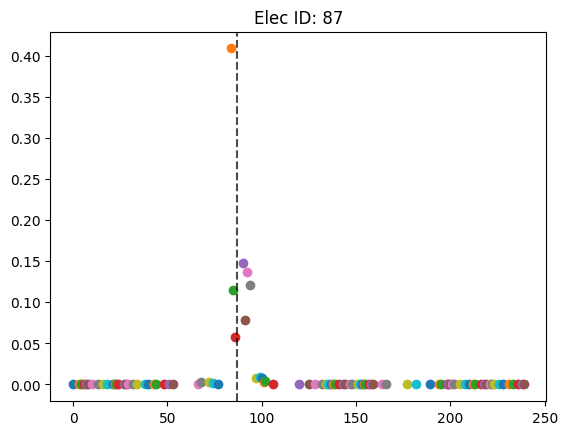

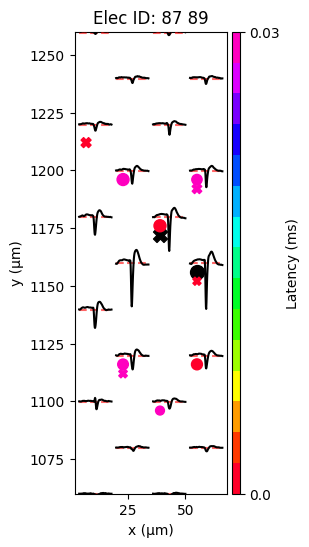

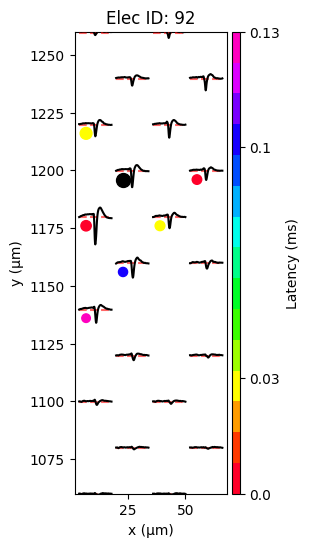

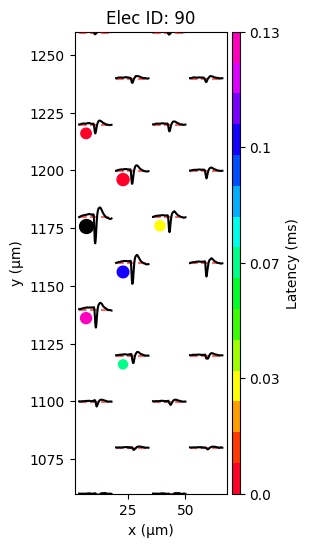

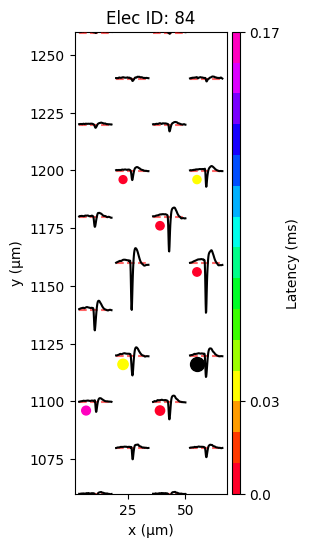

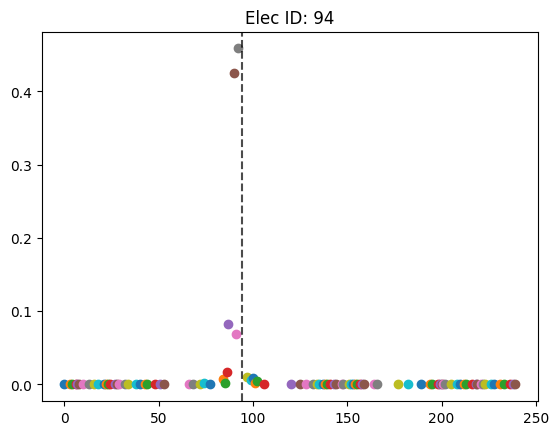

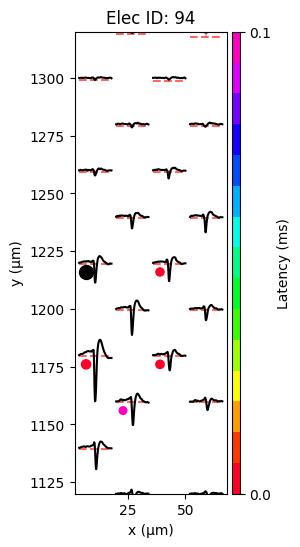

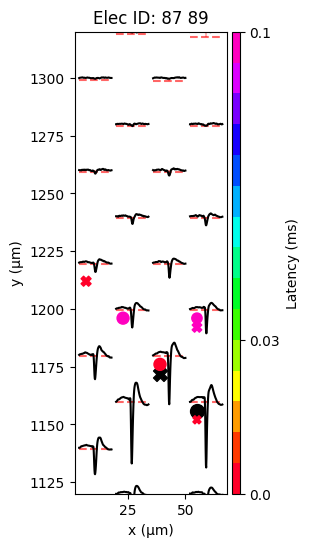

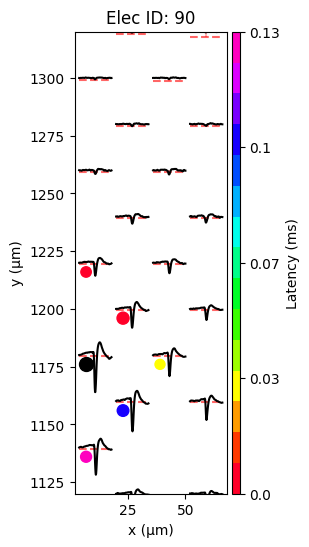

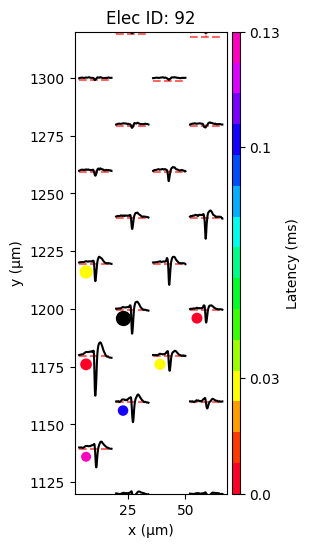

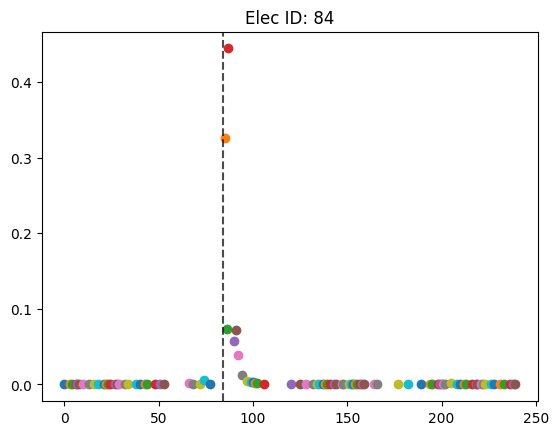

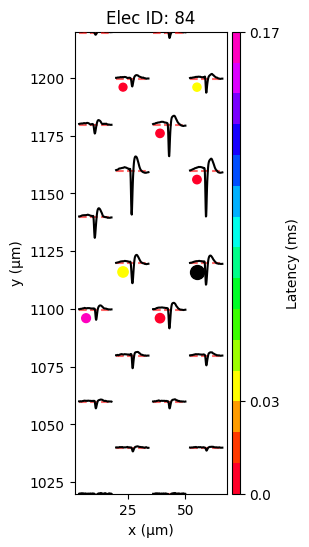

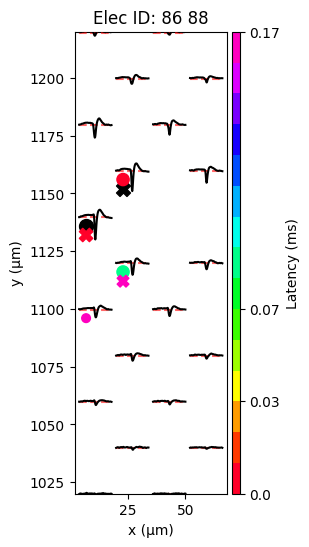

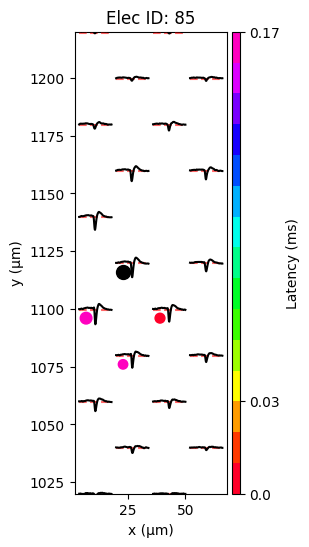

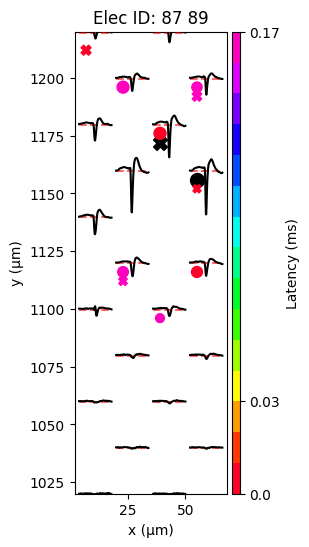

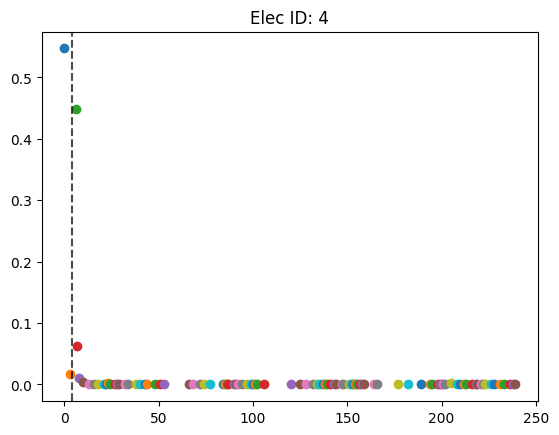

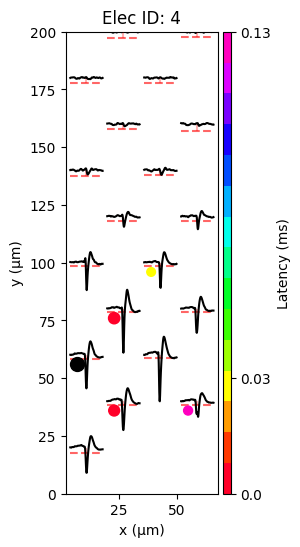

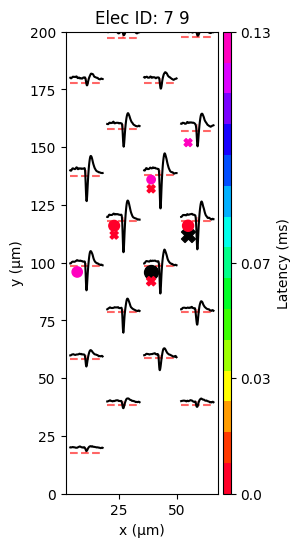

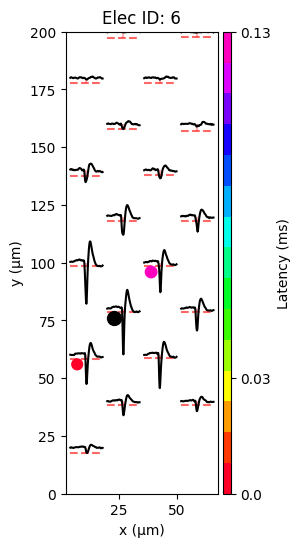

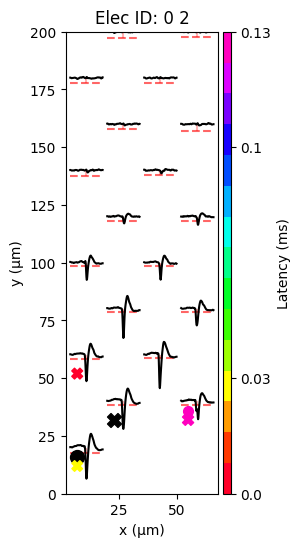

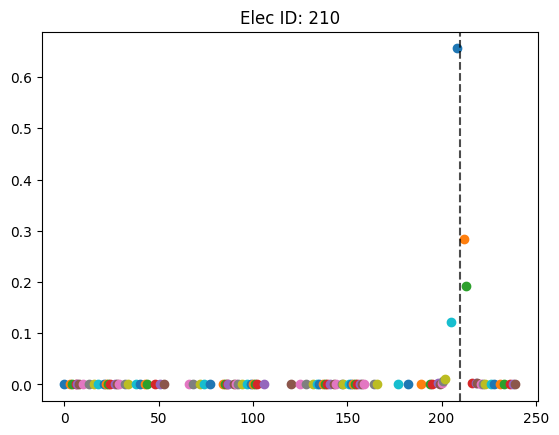

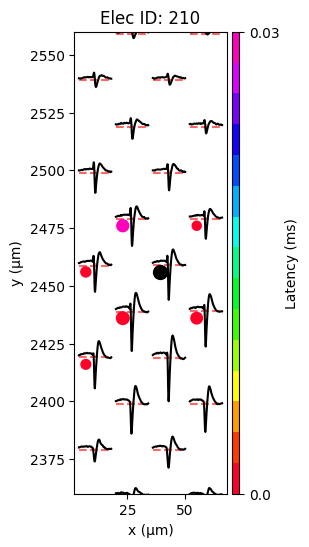

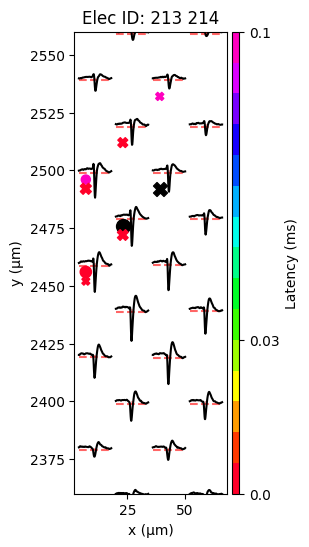

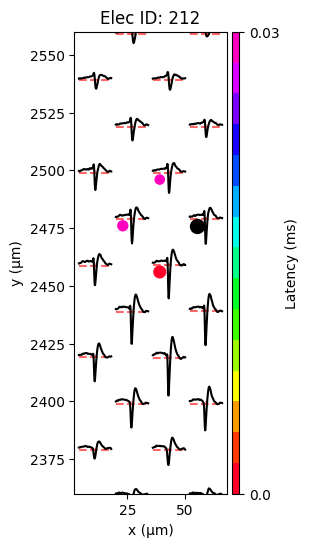

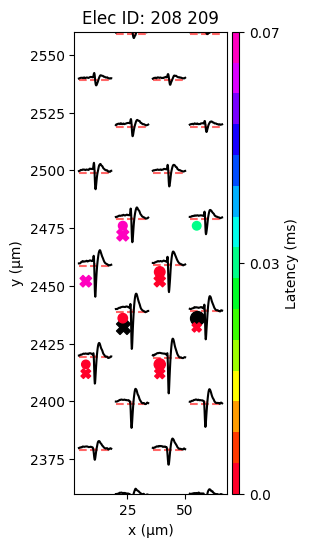

In [31]:
# for i in range(len(prop_signal)):
TOP_N = 3 
for i in UNIT_IND:
    # Get prop
    prop = prop_signal[i]
    ref_id = prop.elec_id
    
    # Plot scatter
    plt.title(f"Elec ID: {ref_id}")
    plt.axvline(ref_id, color="black", linestyle="dashed", alpha=0.7)
    for j in range(len(prop_signal)):
        if i == j:
            continue
        plt.scatter(prop_signal.props[j][0].ID[0], overlap_matrix[i, j])
    plt.show()
    
    # Plot prop
    kwargs = prop.plot(chans_rms=chans_rms, return_kwargs=True)
    
    # Plot top TOP_N props with highest overlap
    for j in np.argsort(overlap_matrix[i, :])[-TOP_N:]:
        comp_prop = prop_signal[j]
        comp_prop.plot(**kwargs)

### Individual spikes

809146.8666666667


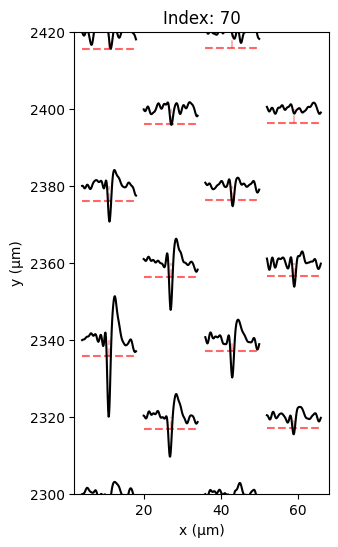

420629.3


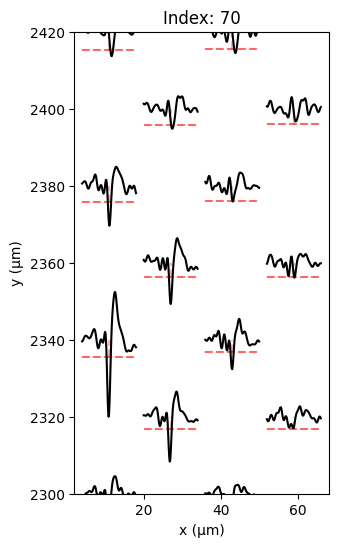

212616.7


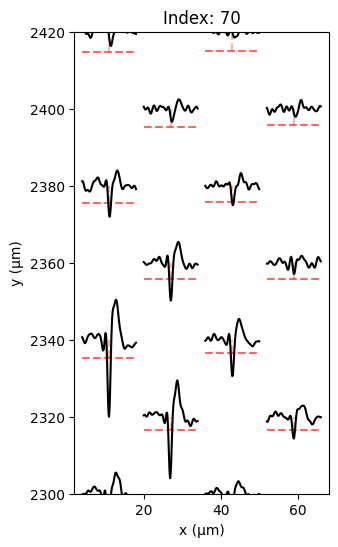

773320.5333333333


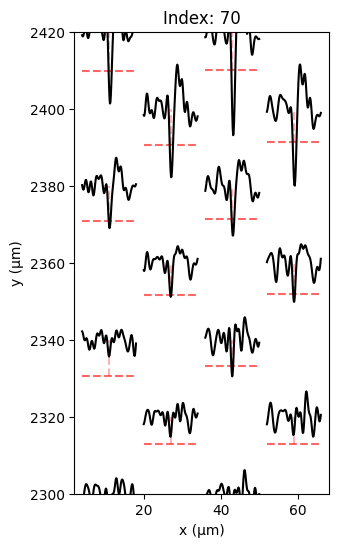

472022.43333333335


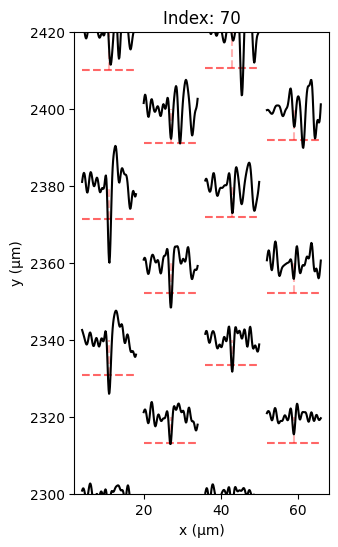

487584.13333333336


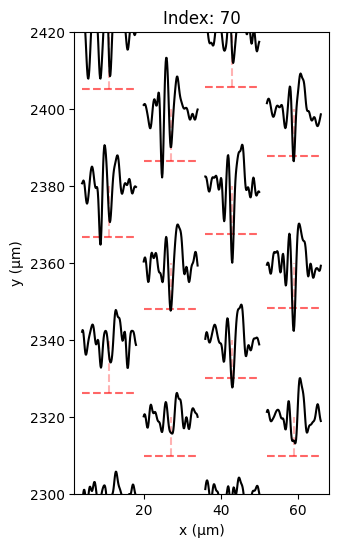

15514.9


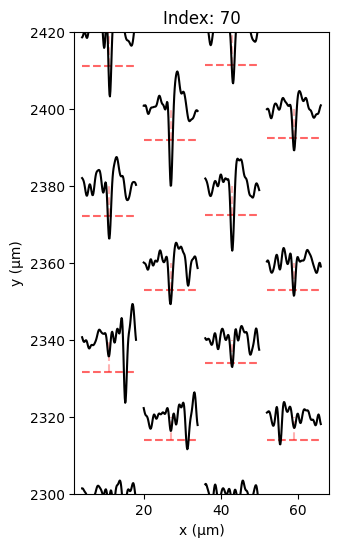

898107.0666666667


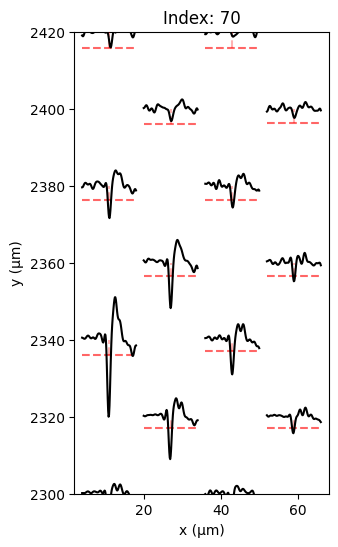

241538.76666666666


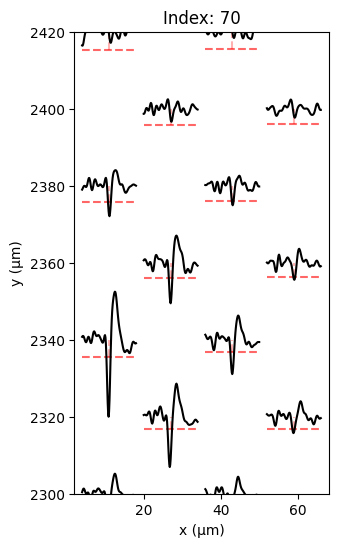

875358.7333333333


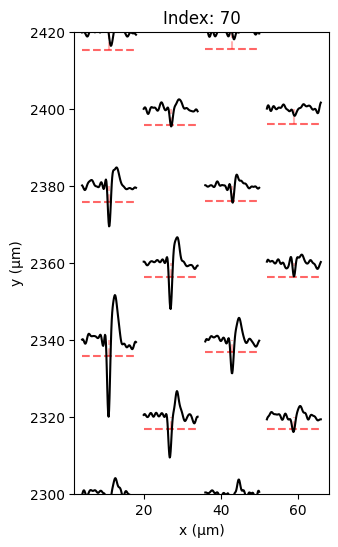

In [170]:
MAX_PLOTS = 10
np.random.seed(101)
##
UNIT1 = prop_signal[70]
UNIT2 = prop_signal[67]

same_spikes = np.intersect1d(UNIT1.spike_train, UNIT2.spike_train)

from src.sorters.prop_signal import PropUnit
for st in np.random.choice(same_spikes, size=MAX_PLOTS):
    print(st)
    super(PropUnit, prop_signal[70]).plot(chans_rms=chans_rms, time=st)

## Comparison with Kilosort2

Mean: 3608.73
STD: 4322.86


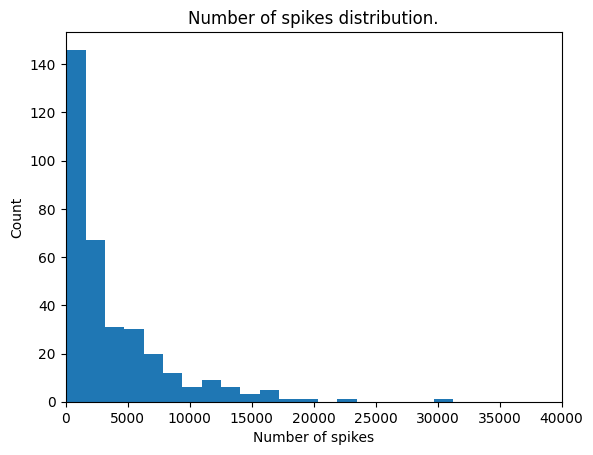

In [62]:
# Load kilosort
kilosort = Kilosort(utils.PATH_SM4_SI, "first", recording)
kilosort.plot_nums_spikes(show=False, bins=20)
plt.xlim(0, 40000)
plt.show()

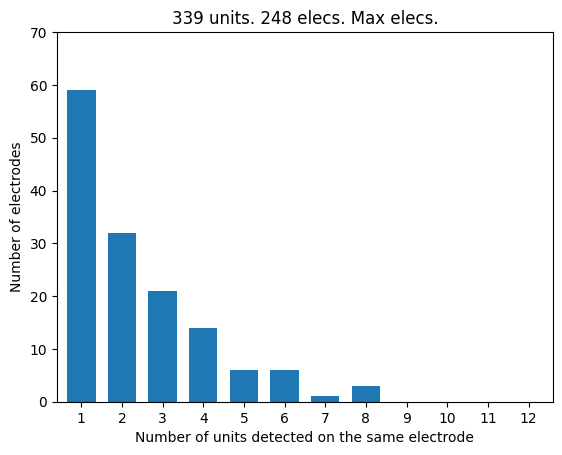

In [113]:
max_chans = []
for i in range(len(kilosort)):
    ks = kilosort[i]
    template = ks.get_template_mean()
    chan = np.argmin(np.min(template, axis=1))
    max_chans.append(chan)
chans, counts = np.unique(max_chans, return_counts=True)

plot.bar(counts, xmax=12)

plt.title(f"{len(kilosort)} units. {kilosort.recording.get_num_channels()} elecs. Max elecs.")
plt.xlabel(f"Number of units detected on the same electrode")
plt.ylabel("Number of electrodes")
plt.ylim(0, 70)
plt.show()


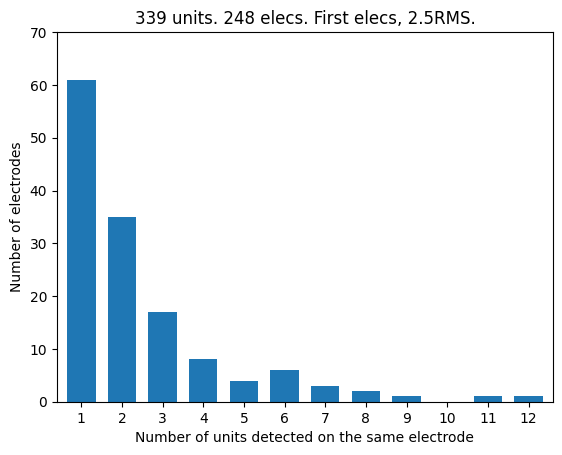

In [112]:
RMS_THRESH = 2.5

chans = []
for unit in kilosort:    
    templates = unit.get_template_mean()
    
    amps = np.min(templates, axis=1)
    elec_mask = amps < -RMS_THRESH * chans_rms
    elecs = np.flatnonzero(elec_mask)
    if elecs.size == 0:
        elecs = [np.argmin(amps)]
    
    latencies = np.argmin(templates, axis=1)
    min_latency = np.min(np.argmin(templates[elecs], axis=1))
    chan = None
    min_amp = np.inf
    for elec in elecs:
        if latencies[elec] == min_latency and amps[elec] < min_amp:
            chan = elec
            min_amp = amps[elec]
    chans.append(chan)
    
_, counts = np.unique(chans, return_counts=True)

plot.bar(counts, xmax=8)

plt.title(f"{len(kilosort)} units. {kilosort.recording.get_num_channels()} elecs. First elecs, {RMS_THRESH}RMS.")

plt.xlabel("Number of units detected on the same electrode")

plt.ylabel("Number of electrodes")
plt.ylim(0, 70)

plt.show()


In [66]:
bars

array([  0,   1,   3,   5,   6,   7,   8,   9,  10,  11,  12,  13,  17,
        18,  20,  21,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,
        33,  34,  35,  36,  38,  39,  40,  41,  42,  43,  44,  45,  46,
        47,  48,  49,  50,  51,  52,  53,  55,  56,  57,  61,  73,  75,
        77,  79,  80,  82,  83,  84,  86,  87,  88,  89,  90,  92,  93,
        94,  95,  96,  97,  98,  99, 104, 118, 124, 127, 128, 129, 130,
       133, 134, 136, 138, 139, 140, 142, 144, 145, 146, 147, 149, 150,
       151, 152, 153, 154, 155, 156, 158, 160, 161, 162, 164, 165, 177,
       180, 181, 184, 188, 193, 195, 196, 197, 198, 199, 202, 203, 204,
       205, 206, 207, 208, 209, 211, 212, 213, 215, 217, 219, 220, 221,
       223, 224, 225, 226, 227, 229, 230, 232, 237, 239, 240, 242])

In [35]:
# Num unique spikes
def count_unique_and_total_spikes(sorter):
    spikes_unique = set()
    total = 0
    for spikes in sorter.get_spike_times():
        spikes_unique.update(spikes)
        total += len(spikes)
    
    # return spikes_unique, spikes_total
    unique = len(spikes_unique)
    
    print(f"Unique/Total: {unique}/{total} = {unique/total*100:.1f}%")

print("Kilosort:")
count_unique_and_total_spikes(kilosort)
print()
print("Prop:")
count_unique_and_total_spikes(prop_signal)

Kilosort:
Unique/Total: 1187625/1223360 = 97.1%

Prop:
Unique/Total: 652455/794044 = 82.2%


Num Prop.: 116
Num Kilosort2: 339
Num single matches: 12

For Prop.:
Num max matches: 25
Num unique max matches: 12

For Kilosort2:
Num max matches: 12
Num unique max matches: 12


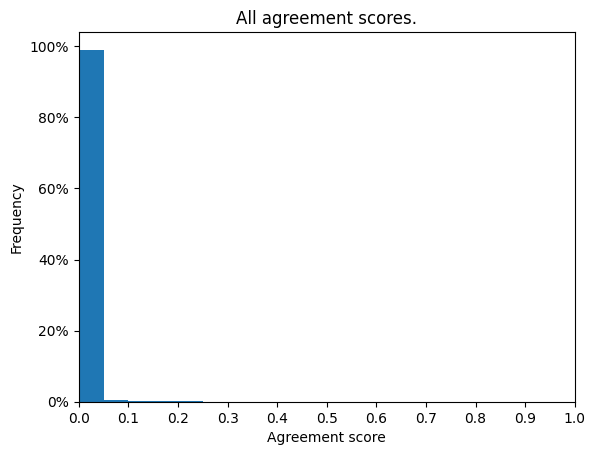

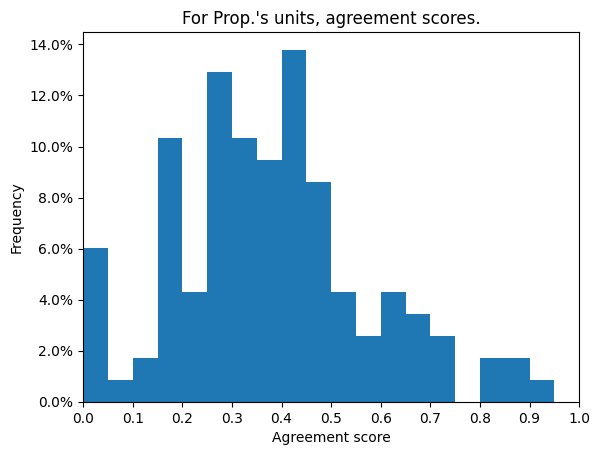

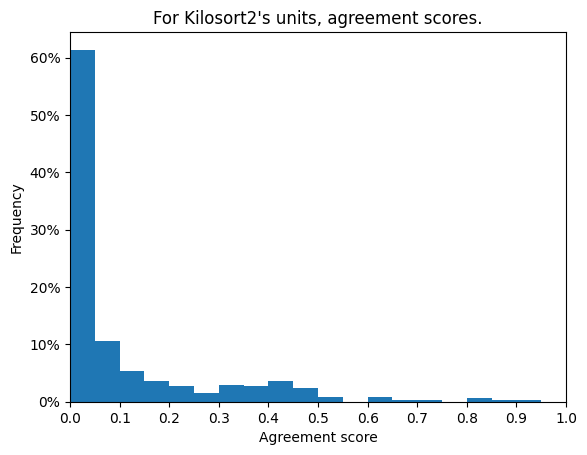

Num Prop.: 116
Num Kilosort2: 339
Num single matches: 32

For Prop.:
Num max matches: 48
Num unique max matches: 32

For Kilosort2:
Num max matches: 32
Num unique max matches: 32


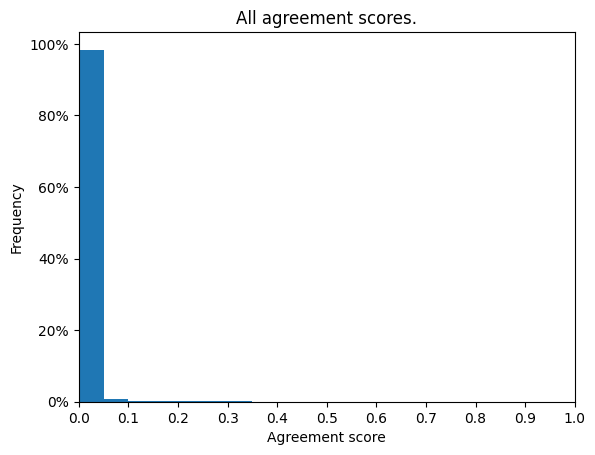

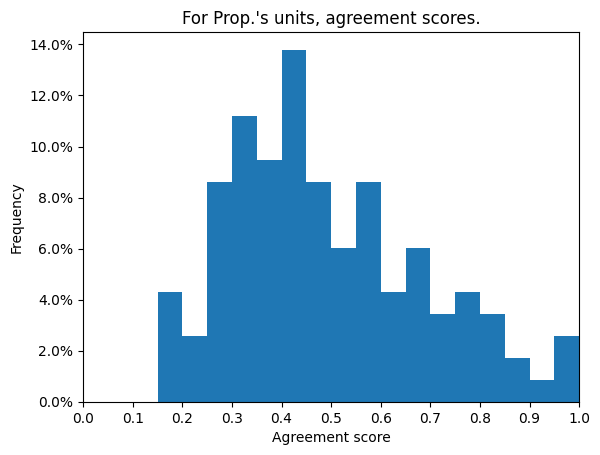

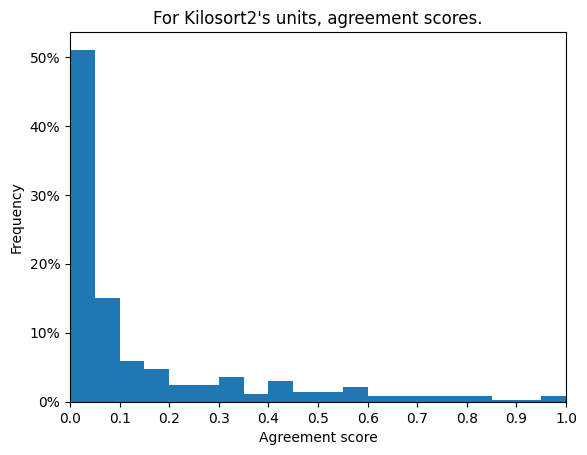

Num Prop.: 116
Num Kilosort2: 339
Num single matches: 81

For Prop.:
Num max matches: 91
Num unique max matches: 53

For Kilosort2:
Num max matches: 118
Num unique max matches: 64


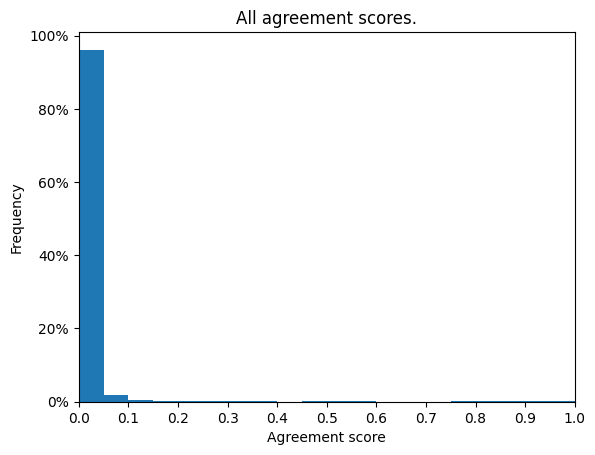

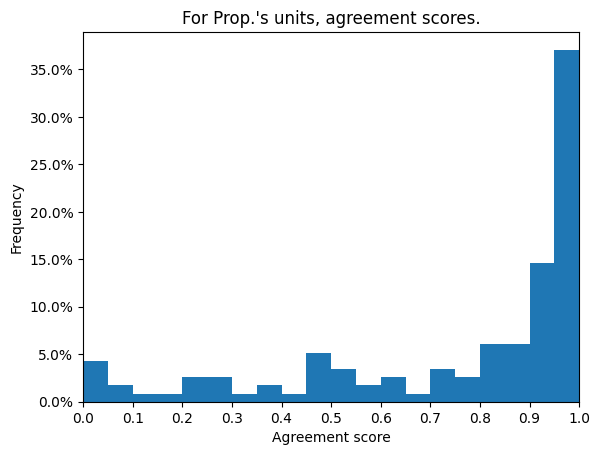

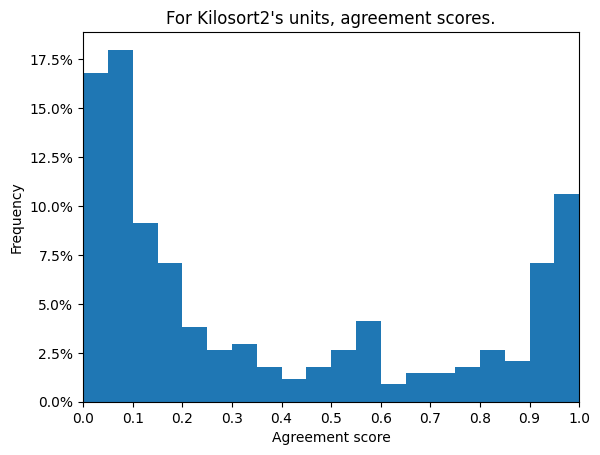

In [217]:
comp_1_5 = Comparison(prop_signal, kilosort, score_formula=1.5)
comp_1_5.summary()

comp_1 = Comparison(prop_signal, kilosort, score_formula=1)
comp_1.summary()

comp_2 = Comparison(prop_signal, kilosort, score_formula=2)
comp_2.summary()

### Line comparison

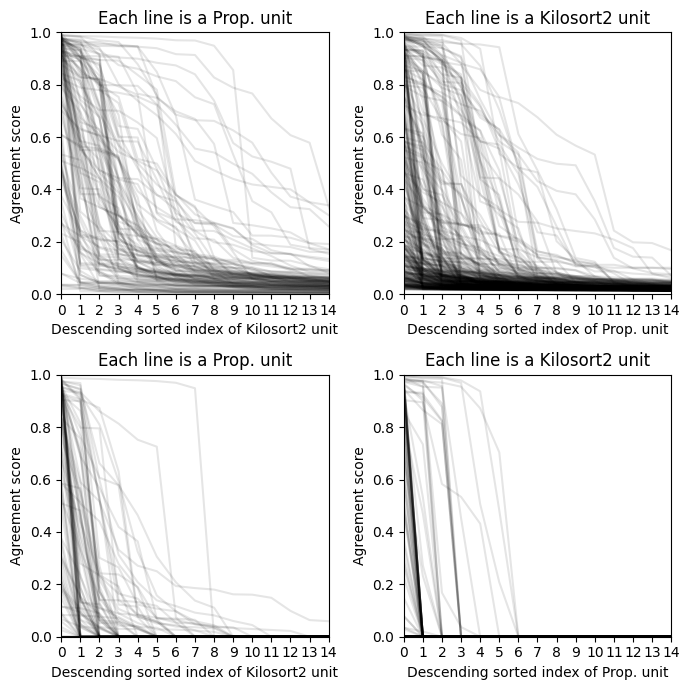

In [218]:
comp_2.plot_line_comps()

In [22]:
ks_matches_ind = np.argsort([len(ks) for ks in matches])
ks_idx = ks_matches_ind[-1]
ks_most = matches[ks_idx]
ks = kilosort[ks_idx]
print(ks_idx, len(ks))
print(len(ks_most))

196 651
6


59 4539
196 651 0.9907834101382489
192 333 0.8318318318318318


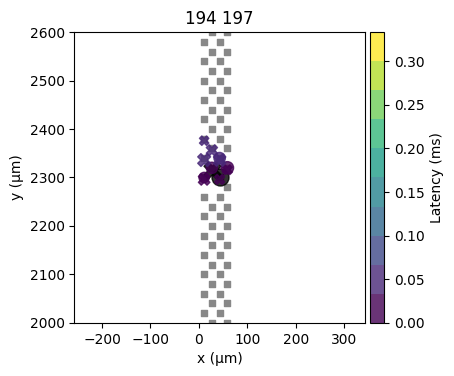

60 2357
196 651 0.9953917050691244
194 69 0.5217391304347826


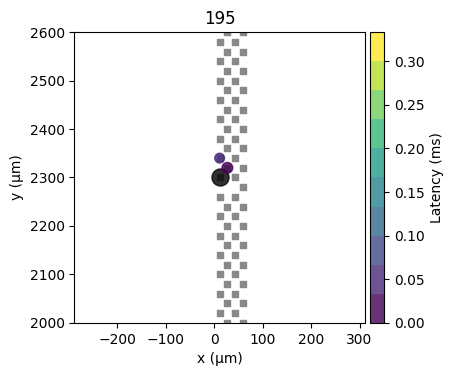

61 3260
196 651 0.9953917050691244
190 346 0.5664739884393064


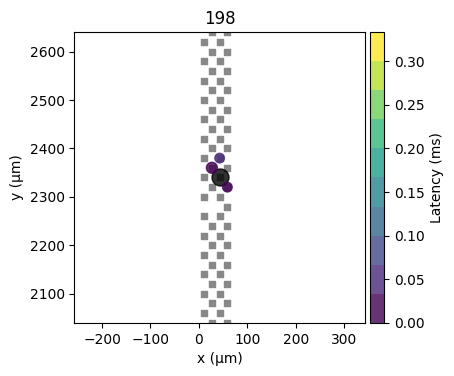

62 5793
196 651 0.978494623655914
197 5612 0.7170349251603706


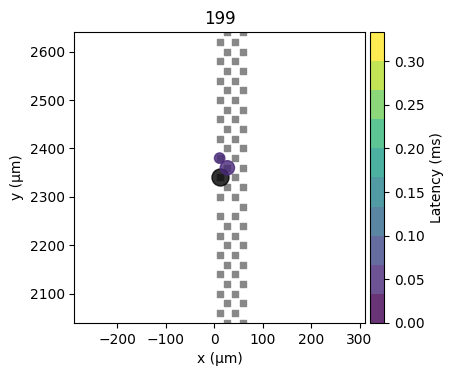

63 2526
196 651 0.8218125960061444
196 651 0.8218125960061444


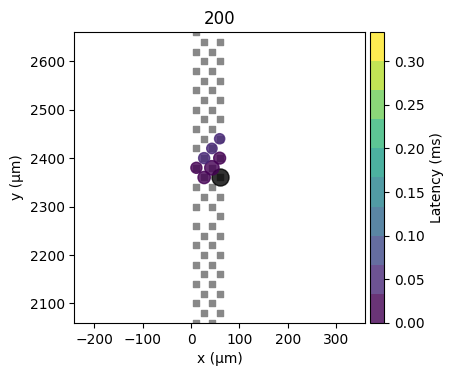

64 5424
196 651 0.9831029185867896
199 899 0.9555061179087876


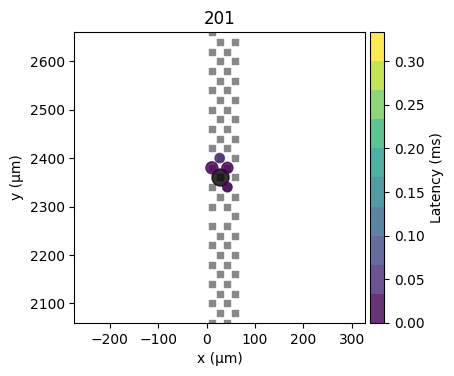

In [23]:
for prop_idx in ks_most:
    prop = comp_2.sorter1[prop_idx]
    print(prop_idx, len(prop))
    print(ks_idx, len(ks), comp_2.count_matching_events(ks.spike_train, prop.spike_train) / ks.spike_train.size)
    
    # Find matching kilosort unit
    for pid, kid in comp_2.matching_uids:
        if pid == prop_idx:
            ks_max = kilosort[kid]
            print(kid, len(ks_max), comp_2.count_matching_events(ks_max.spike_train, prop.spike_train) / ks_max.spike_train.size)
            break
    else:
        print(None)
    
    prop.plot()

In [24]:
ks_idx = ks_matches_ind[-3]
ks_most = matches[ks_idx]
ks = kilosort[ks_idx]
print(ks_idx, len(ks))
print(len(ks_most))

206 1948
5


68 7202
206 1948 0.9034907597535934
206 1948 0.9034907597535934


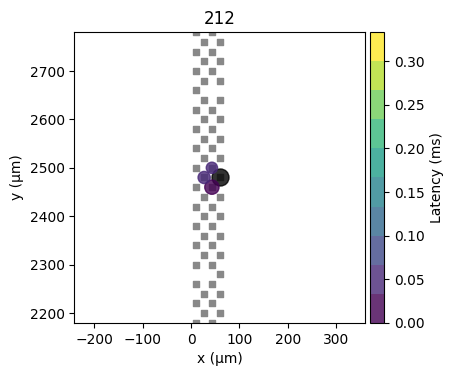

70 7746
206 1948 0.8341889117043121
None


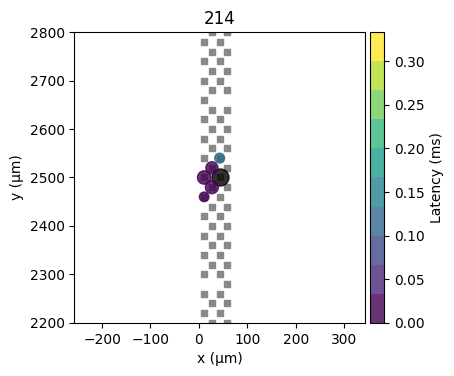

71 2791
206 1948 0.5893223819301848
None


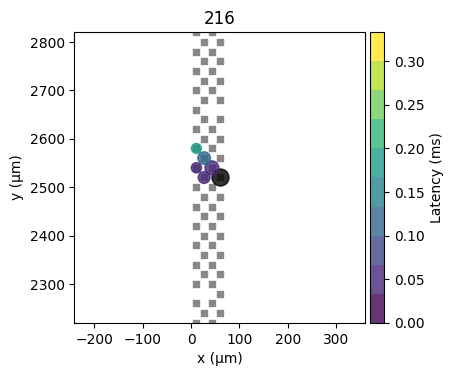

72 9147
206 1948 0.8947638603696099
218 11449 0.5947244300812298


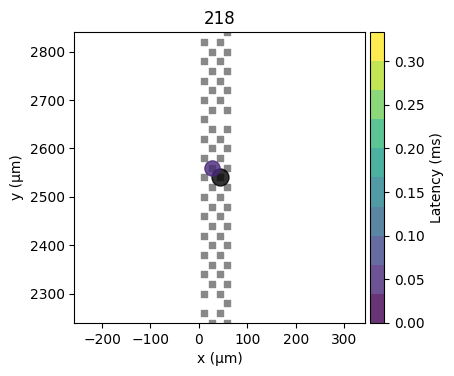

74 3640
206 1948 0.5338809034907598
305 644 0.5108695652173914


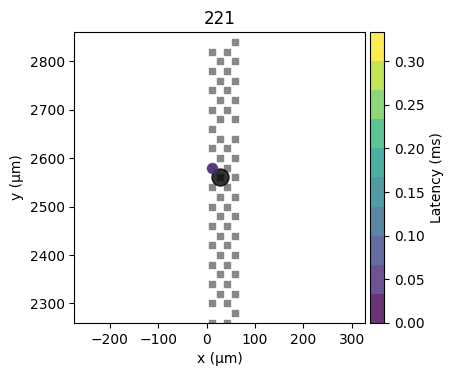

In [25]:
for prop_idx in ks_most:
    prop = comp_2.sorter1[prop_idx]
    print(prop_idx, len(prop))
    print(ks_idx, len(ks), comp_2.count_matching_events(ks.spike_train, prop.spike_train) / ks.spike_train.size)
    
    # Find matching kilosort unit
    for pid, kid in comp_2.matching_uids:
        if pid == prop_idx:
            ks_max = kilosort[kid]
            print(kid, len(ks_max), comp_2.count_matching_events(ks_max.spike_train, prop.spike_train) / ks_max.spike_train.size)
            break
    else:
        print(None)
    
    prop.plot()

In [26]:
ks_idx = ks_matches_ind[-4]
ks_most = matches[ks_idx]
ks = kilosort[ks_idx]
print(ks_idx, len(ks))
print(len(ks_most))

123 4155
3


31 16002
123 4155 0.9665463297232251
117 3285 0.8964992389649924


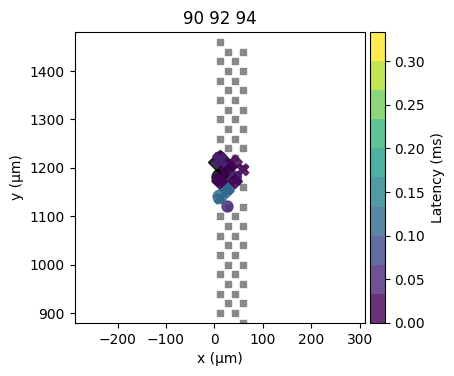

32 12082
123 4155 0.9725631768953069
122 651 0.5422427035330261


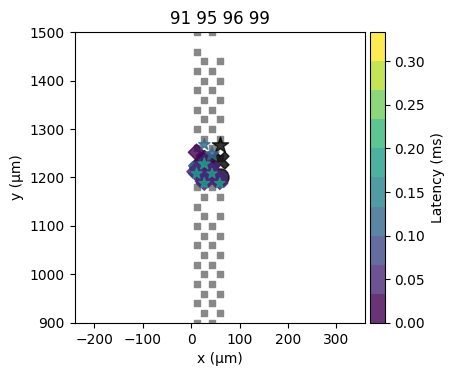

33 6007
123 4155 0.9903730445246691
123 4155 0.9903730445246691


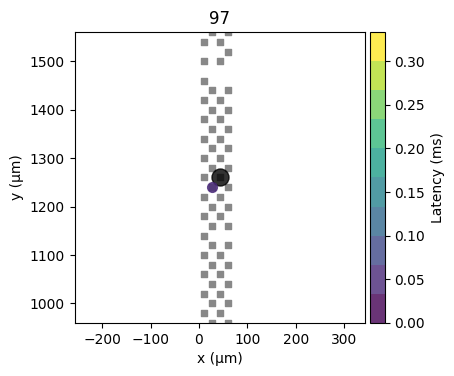

In [27]:
for prop_idx in ks_most:
    prop = comp_2.sorter1[prop_idx]
    print(prop_idx, len(prop))
    print(ks_idx, len(ks), comp_2.count_matching_events(ks.spike_train, prop.spike_train) / ks.spike_train.size)
    
    # Find matching kilosort unit
    for pid, kid in comp_2.matching_uids:
        if pid == prop_idx:
            ks_max = kilosort[kid]
            print(kid, len(ks_max), comp_2.count_matching_events(ks_max.spike_train, prop.spike_train) / ks_max.spike_train.size)
            break
    else:
        print(None)
    
    prop.plot()

### Heat map
Could you please make a heatmap figure with a 2D grid of threshold values. For each combination of threshold values, could you see how many prop units that don't have the highest overlap score with kilosort still have an overlap score of at least 0.5? That could help give us more insight in the effect of these two thresholds on the number of potentially undermerged units prop units.

In [43]:
# Get values for heatmap
SEQ_ORDER_MAX_VALUES = [-0.1, 0, 0.5, 1, 2, 4]
REL_AMP_MAX_VALUES = [0, 0.05, 0.1, 0.2, 0.4, 0.6]

MATCH_SCORE = 0.5  # Minimum agreement score to be considered a match
##
matches_matrix = np.zeros((len(SEQ_ORDER_MAX_VALUES), len(REL_AMP_MAX_VALUES)), dtype=int)
for s, seq_order_max in tqdm(enumerate(SEQ_ORDER_MAX_VALUES), total=len(SEQ_ORDER_MAX_VALUES)):
    for r, rel_amp_max in enumerate(REL_AMP_MAX_VALUES):
        no_merge_ind_seq = no_merge_ind_elec | (merge_scores[:, 2] > seq_order_max)
        pdist = merge_scores[:, 3].copy()
        pdist[no_merge_ind_seq] = REL_AMP_EXTREMUM
        props_m, times_m = merge(rel_amp_max, return_times=True)
        prop_signal = PropSignal([props_m, times_m], recording)
        
        comp = Comparison(prop_signal, kilosort, score_formula=2, match_score=MATCH_SCORE)
        num_matches = 0
        for k in range(len(comp.match21)):
            num_matches += np.sum(comp.agreement_scores[:, k] >= MATCH_SCORE)
            if comp.match21[k] != -1:  # Kilosort unit has a match (i.e. a prop unit with >=MATCH_SCORE)
                num_matches -= 1
        matches_matrix[s, r] = num_matches

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [08:52<00:00, 88.69s/it] 


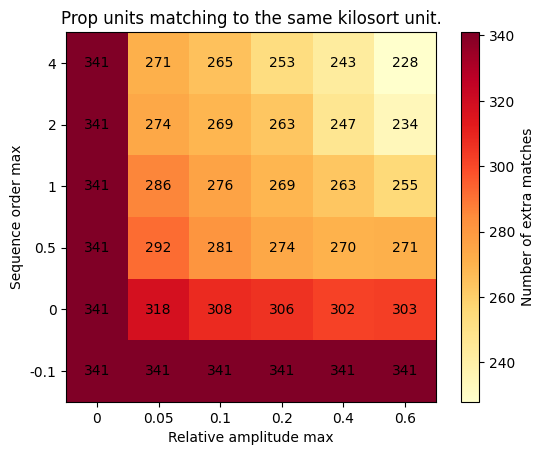

In [45]:
# Create heatmap
TEXT_COLOR = "black"
##
fig, ax = plt.subplots()
heatmap = ax.imshow(matches_matrix, cmap="YlOrRd", origin="lower")

# Set axis labels
ax.set_xlabel("Relative amplitude max")
ax.set_xticks(range(len(REL_AMP_MAX_VALUES)))
ax.set_xticklabels(REL_AMP_MAX_VALUES)

ax.set_ylabel("Sequence order max")
ax.set_yticks(range(len(SEQ_ORDER_MAX_VALUES)))
ax.set_yticklabels(SEQ_ORDER_MAX_VALUES)

# Show the colorbar
cbar = plt.colorbar(heatmap)
cbar.set_label("Number of extra matches")

# Annotate the cells with the condition count
for s in range(matches_matrix.shape[0]):
    for r in range(matches_matrix.shape[1]):
        num_matches = matches_matrix[s, r]
        ax.text(r, s, num_matches, ha="center", va="center", color=TEXT_COLOR)

# Set title
ax.set_title("Prop units matching to the same kilosort unit.")

# Show the plot
plt.show()